<font size=15 color="orange"><b> Modelo de Prediccion de Papers - Basado En Arxiv </b></font>

# Descarga De Datos

In [ ]:
import arxiv
import pandas as pd
import numpy as np
import concurrent.futures
import time
from datetime import datetime
import re

def descargar_categoria_turbo_completa(categoria_info):
    """Versión ULTRA RÁPIDA con TODOS los metadatos"""
    categoria, nombre_categoria, papers_objetivo = categoria_info
    
    try:
        # CONSULTA MASIVA - máxima velocidad
        search = arxiv.Search(
            query=f"cat:{categoria}",
            max_results=2000,  # Máximo de arXiv
            sort_by=arxiv.SortCriterion.SubmittedDate,
            sort_order=arxiv.SortOrder.Descending
        )
        
        client = arxiv.Client()
        resultados = list(client.results(search))
        
        # Mezclar y tomar objetivo
        np.random.shuffle(resultados)
        papers_categoria = []
        
        for paper in resultados[:papers_objetivo]:
            # EXTRAER TODOS LOS METADATOS RÁPIDAMENTE
            papers_categoria.append({
                # Identificación básica (igual que tu versión rápida)
                'id': paper.entry_id,
                'title': paper.title,
                'abstract': paper.summary,
                'category': categoria,
                'category_name': nombre_categoria,
                'authors': ';'.join([str(author) for author in paper.authors]),  # String para ahorrar espacio
                'published': paper.published.date() if paper.published else None,
                'pdf_url': paper.pdf_url,
                'primary_category': paper.primary_category,
                
                # METADATOS EXTRA del código completo (pero rápidos)
                'categories': ';'.join(paper.categories) if paper.categories else '',
                'updated': paper.updated.date() if paper.updated else None,
                'journal_ref': paper.journal_ref if paper.journal_ref else '',
                'doi': paper.doi if paper.doi else '',
                'comment': paper.comment[:500] if paper.comment else '',  # Limitar tamaño
            })
        
        return papers_categoria
        
    except Exception as e:
        print(f" Error en {categoria}: {e}")
        return []

def calcular_metricas_rapidas(df):
    """
    Calcula solo las métricas ESENCIALES de forma RÁPIDA
    """
    print("\n  MÉTRICAS ")
    
    df_metricas = df.copy()
    
    # 1. Métricas básicas instantáneas
    df_metricas['num_authors'] = df_metricas['authors'].str.count(';') + 1
    df_metricas['abstract_length'] = df_metricas['abstract'].str.len()
    
    # 2. Actualidad (solo lo esencial)
    df_metricas['published'] = pd.to_datetime(df_metricas['published'])
    df_metricas['days_since_published'] = (pd.Timestamp.now() - df_metricas['published']).dt.days
    df_metricas['is_recent'] = (df_metricas['days_since_published'] < 365).astype(int)  # < 1 año
    
    # 3. Indicadores de calidad (rápidos)
    df_metricas['has_journal_ref'] = df_metricas['journal_ref'].str.strip().ne('').astype(int)
    df_metricas['has_doi'] = df_metricas['doi'].str.strip().ne('').astype(int)
    
    # 4. Detección de tipo (SOLO las más importantes)
    title_abstract = df_metricas['title'] + ' ' + df_metricas['abstract']
    
    # Tutorial vs Aplicación vs Teórico
    df_metricas['is_tutorial'] = title_abstract.str.lower().apply(
        lambda x: any(keyword in x for keyword in ['tutorial', 'survey', 'review'])
    ).astype(int)
    
    df_metricas['is_application'] = title_abstract.str.lower().apply(
        lambda x: any(keyword in x for keyword in ['application', 'system', 'framework', 'practical'])
    ).astype(int)
    
    df_metricas['is_theoretical'] = title_abstract.str.lower().apply(
        lambda x: any(keyword in x for keyword in ['theory', 'theoretical', 'proof'])
    ).astype(int)
    
    # 5. Score de calidad simple pero efectivo
    df_metricas['quality_score'] = (
        df_metricas['has_journal_ref'] * 0.4 +
        df_metricas['is_recent'] * 0.3 +
        df_metricas['num_authors'].clip(0, 10) * 0.1 +
        df_metricas['abstract_length'].clip(0, 2000) / 2000 * 0.2
    )
    
    print(" Métricas  calculadas")
    return df_metricas

def obtener_datos_turbo_mejorado(papers_por_categoria=2000, max_categorias=None):
    """
    VERSIÓN MEJORADA: Velocidad TURBO + Metadatos COMPLETOS
    """
    
    print(" INICIANDO DESCARGA ")
    
    # USAMOS LAS MISMAS CATEGORÍAS COMPLETAS (que funcionaron bien)
    categorias_completas = {
        'cs.AI': 'Artificial Intelligence', 'cs.LG': 'Machine Learning', 'cs.CV': 'Computer Vision',
        'cs.CL': 'Computational Linguistics', 'cs.NE': 'Neural and Evolutionary Computing', 'cs.RO': 'Robotics',
        'cs.SI': 'Social and Information Networks', 'cs.SY': 'Systems and Control', 'cs.CR': 'Cryptography and Security',
        'cs.DC': 'Distributed, Parallel, and Cluster Computing', 'cs.DS': 'Data Structures and Algorithms', 'cs.DB': 'Databases',
        'cs.IR': 'Information Retrieval', 'cs.SE': 'Software Engineering', 'physics.comp-ph': 'Computational Physics',
        'physics.data-an': 'Data Analysis, Statistics and Probability', 'physics.optics': 'Optics', 'physics.flu-dyn': 'Fluid Dynamics',
        'physics.med-ph': 'Medical Physics', 'physics.acc-ph': 'Accelerator Physics', 'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
        'cond-mat.mtrl-sci': 'Materials Science', 'cond-mat.stat-mech': 'Statistical Mechanics', 'hep-ph': 'High Energy Physics - Phenomenology',
        'hep-th': 'High Energy Physics - Theory', 'hep-ex': 'High Energy Physics - Experiment', 'math.NA': 'Numerical Analysis',
        'math.OC': 'Optimization and Control', 'math.ST': 'Statistics Theory', 'math.PR': 'Probability', 'math.DS': 'Dynamical Systems',
        'math.IT': 'Information Theory', 'stat.ML': 'Machine Learning', 'stat.TH': 'Statistics Theory', 'stat.AP': 'Applications',
        'stat.ME': 'Methodology', 'q-bio.NC': 'Neurons and Cognition', 'q-bio.QM': 'Quantitative Methods', 'q-bio.GN': 'Genomics',
        'q-bio.BM': 'Biomolecules', 'q-fin.ST': 'Statistical Finance', 'q-fin.TR': 'Trading and Market Microstructure',
        'q-fin.PM': 'Portfolio Management', 'econ.EM': 'Econometrics', 'econ.TH': 'Theoretical Economics', 'econ.GN': 'General Economics',
        'eess.AS': 'Audio and Speech Processing', 'eess.IV': 'Image and Video Processing', 'eess.SP': 'Signal Processing', 'eess.SY': 'Systems and Control'
    }
    
    if max_categorias and max_categorias < len(categorias_completas):
        categorias_seleccionadas = dict(list(categorias_completas.items())[:max_categorias])
    else:
        categorias_seleccionadas = categorias_completas
    
    print(f" OBJETIVO: {len(categorias_seleccionadas)} categorías × {papers_por_categoria} papers")
    print(f" TOTAL ESPERADO: {len(categorias_seleccionadas) * papers_por_categoria:,} papers")
    print(f" MODO: TURBO MEJORADO - Velocidad máxima + Metadatos completos")
    
    # PREPARAR DESCARGAS PARALELAS
    categorias_info = [
        (cat, nombre, papers_por_categoria) 
        for cat, nombre in categorias_seleccionadas.items()
    ]
    
    all_papers = []
    start_time = time.time()
    
    print(f"\n  DESCARGAS ")
    
    # DESCARGAR EN PARALELO - 12 workers para MÁXIMA velocidad
    with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
        future_to_cat = {executor.submit(descargar_categoria_turbo_completa, info): info[0] for info in categorias_info}
        
        completed = 0
        for future in concurrent.futures.as_completed(future_to_cat):
            cat = future_to_cat[future]
            try:
                resultado = future.result()
                if resultado:
                    all_papers.extend(resultado)
                    completed += 1
                    print(f" [{completed}/{len(categorias_info)}] {cat}: {len(resultado)} papers completos")
                else:
                    completed += 1
                    print(f"❌ [{completed}/{len(categorias_info)}] {cat}: Falló")
            except Exception as e:
                completed += 1
                print(f" [{completed}/{len(categorias_info)}] {cat}: Error - {e}")
    
    # Crear DataFrame base
    df = pd.DataFrame(all_papers)
    
    # ELIMINAR DUPLICADOS (crítico para velocidad)
    initial_count = len(df)
    df = df.drop_duplicates(subset=['id'])
    duplicates_removed = initial_count - len(df)
    if duplicates_removed > 0:
        print(f" Eliminados {duplicates_removed} duplicados")
    
    # CALCULAR MÉTRICAS RÁPIDAS
    df_completo = calcular_metricas_rapidas(df)
    
    # Mezclar final
    df_completo = df_completo.sample(frac=1, random_state=42).reset_index(drop=True)
    
    elapsed = time.time() - start_time
    papers_per_second = len(df_completo) / elapsed if elapsed > 0 else 0
    
    print(f"\n DESCARGA TURBO MEJORADA COMPLETADA!")
    print(f" PAPERS DESCARGADOS: {len(df_completo):,}")
    print(f"  CATEGORÍAS: {df_completo['category'].nunique()}")
    print(f" TIEMPO TOTAL: {elapsed:.1f} segundos ({elapsed/60:.1f} minutos)")
    print(f" VELOCIDAD: {papers_per_second:.1f} papers/segundo")
    
    return df_completo

# EJECUTAR DESCARGA TURBO MEJORADA
print("="*80)
print(" EJECUTANDO DESCARGA TURBO MEJORADA - VELOCIDAD + COMPLETITUD")
print("="*80)

# CONFIGURACIÓN ÓPTIMA BASADA EN TU ÉXITO ANTERIOR
df_turbo_mejorado = obtener_datos_turbo_mejorado(
    papers_por_categoria=2000,  # Mismo que tu versión exitosa
    max_categorias=None         # TODAS las categorías
)

# GUARDAR DATOS COMPLETOS
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"arxiv_turbo_mejorado_{len(df_turbo_mejorado)}_papers_{timestamp}.csv"
df_turbo_mejorado.to_csv(filename, index=False)

print(f"\n ARCHIVO GUARDADO: {filename}")

# INFORME COMPACTO PERO COMPLETO
print(f"\n INFORME FINAL - MEJORADO:")
print(f" ESTADÍSTICAS BÁSICAS:")
print(f"   • Total papers: {len(df_turbo_mejorado):,}")
print(f"   • Categorías únicas: {df_turbo_mejorado['category'].nunique()}")
print(f"   • Rango temporal: {df_turbo_mejorado['published'].min()} a {df_turbo_mejorado['published'].max()}")
print(f"\n METADATOS CAPTURADOS:")
print(f"   • Con referencia de revista: {df_turbo_mejorado['has_journal_ref'].sum():,}")
print(f"   • Con DOI: {df_turbo_mejorado['has_doi'].sum():,}")
print(f"   • Recientes (<1 año): {df_turbo_mejorado['is_recent'].sum():,}")
print(f"   • Tutoriales/Reviews: {df_turbo_mejorado['is_tutorial'].sum():,}")
print(f"   • Aplicaciones prácticas: {df_turbo_mejorado['is_application'].sum():,}")
print(f"   • Teóricos: {df_turbo_mejorado['is_theoretical'].sum():,}")

# VERIFICACIÓN DE CAMPOS
print(f"\n CAMPOS INCLUIDOS ({len(df_turbo_mejorado.columns)} total):")
campos_por_tipo = {
    "Identificación": ['id', 'title', 'abstract'],
    "Categorización": ['category', 'category_name', 'primary_category', 'categories'],
    "Autores": ['authors', 'num_authors'],
    "Fechas": ['published', 'updated', 'days_since_published'],
    "Calidad": ['journal_ref', 'doi', 'comment', 'has_journal_ref', 'has_doi', 'quality_score'],
    "Tipo de contenido": ['is_tutorial', 'is_application', 'is_theoretical'],
    "Enlaces": ['pdf_url']
}

for tipo, campos in campos_por_tipo.items():
    print(f"   • {tipo}: {', '.join(campos)}")

# EJEMPLOS DE DIFERENTES TIPOS
print(f"\n EJEMPLOS DE CONTENIDO:")
print(f" TUTORIAL: {df_turbo_mejorado[df_turbo_mejorado['is_tutorial'] == 1]['title'].iloc[0][:80]}...")
print(f" APLICACIÓN: {df_turbo_mejorado[df_turbo_mejorado['is_application'] == 1]['title'].iloc[0][:80]}...")
print(f" TEÓRICO: {df_turbo_mejorado[df_turbo_mejorado['is_theoretical'] == 1]['title'].iloc[0][:80]}...")

print(f"\n LISTO PARA EL SIGUIENTE PASO:")
print(f"   • Dataset: {filename}")
print(f"   • Tamaño: {len(df_turbo_mejorado):,} papers con {len(df_turbo_mejorado.columns)} campos cada uno")
print(f"   • Próximo: Preprocesamiento y modelo transformer")

🚀 EJECUTANDO DESCARGA TURBO MEJORADA - VELOCIDAD + COMPLETITUD
⚡ INICIANDO DESCARGA TURBO MEJORADA...
🎯 OBJETIVO: 50 categorías × 1000 papers
📊 TOTAL ESPERADO: 50,000 papers
🚀 MODO: TURBO MEJORADO - Velocidad máxima + Metadatos completos

🚀 INICIANDO DESCARGAS PARALELAS TURBO...
❌ [1/50] cs.SY: Falló
✅ [2/50] cs.SI: 1000 papers completos
✅ [3/50] cs.CV: 1000 papers completos
✅ [4/50] cs.IR: 1000 papers completos
✅ [5/50] cs.CL: 1000 papers completos
✅ [6/50] cs.DC: 1000 papers completos
✅ [7/50] cs.RO: 1000 papers completos
✅ [8/50] cs.LG: 1000 papers completos
✅ [9/50] cs.DS: 1000 papers completos
✅ [10/50] cs.DB: 1000 papers completos
✅ [11/50] cs.NE: 1000 papers completos
✅ [12/50] cs.AI: 1000 papers completos
✅ [13/50] cs.CR: 1000 papers completos
✅ [14/50] cs.SE: 1000 papers completos
✅ [15/50] physics.comp-ph: 1000 papers completos
✅ [16/50] physics.flu-dyn: 1000 papers completos
✅ [17/50] cond-mat.mtrl-sci: 1000 papers completos
✅ [18/50] hep-th: 1000 papers completos
✅ [19/50] 

# Pre-REPROCESAMIENTO

 CARGANDO DATASET MEJORADO
 Dataset cargado: 43,453 papers
 Columnas disponibles: ['id', 'title', 'abstract', 'category', 'category_name', 'authors', 'published', 'pdf_url', 'primary_category', 'categories', 'updated', 'journal_ref', 'doi', 'comment', 'num_authors', 'abstract_length', 'days_since_published', 'is_recent', 'has_journal_ref', 'has_doi', 'is_tutorial', 'is_application', 'is_theoretical', 'quality_score']

 INICIANDO PREPROCESAMIENTO AVANZADO OPTIMIZADO...
📝 Procesando textos...
🏷️  Codificando categorías...
📊 Calculando métricas de texto...
🎯 Analizando temas principales...
🚀 Identificando papers frontera...
📈 Mejorando metadatos...

✅ PREPROCESAMIENTO COMPLETADO:
   📊 Papers procesados: 43,453
   🏷️  Categorías únicas: 47
   📏 Longitud promedio: 1261 caracteres
   📝 Palabras promedio: 185
   🚀 Papers frontera: 35,064
   👥 Distribución de perfiles:
      • estudiante: 20,784 (47.8%)
      • investigador: 16,038 (36.9%)
      • industria: 6,631 (15.3%)

📈 CREANDO VISUALIZAC

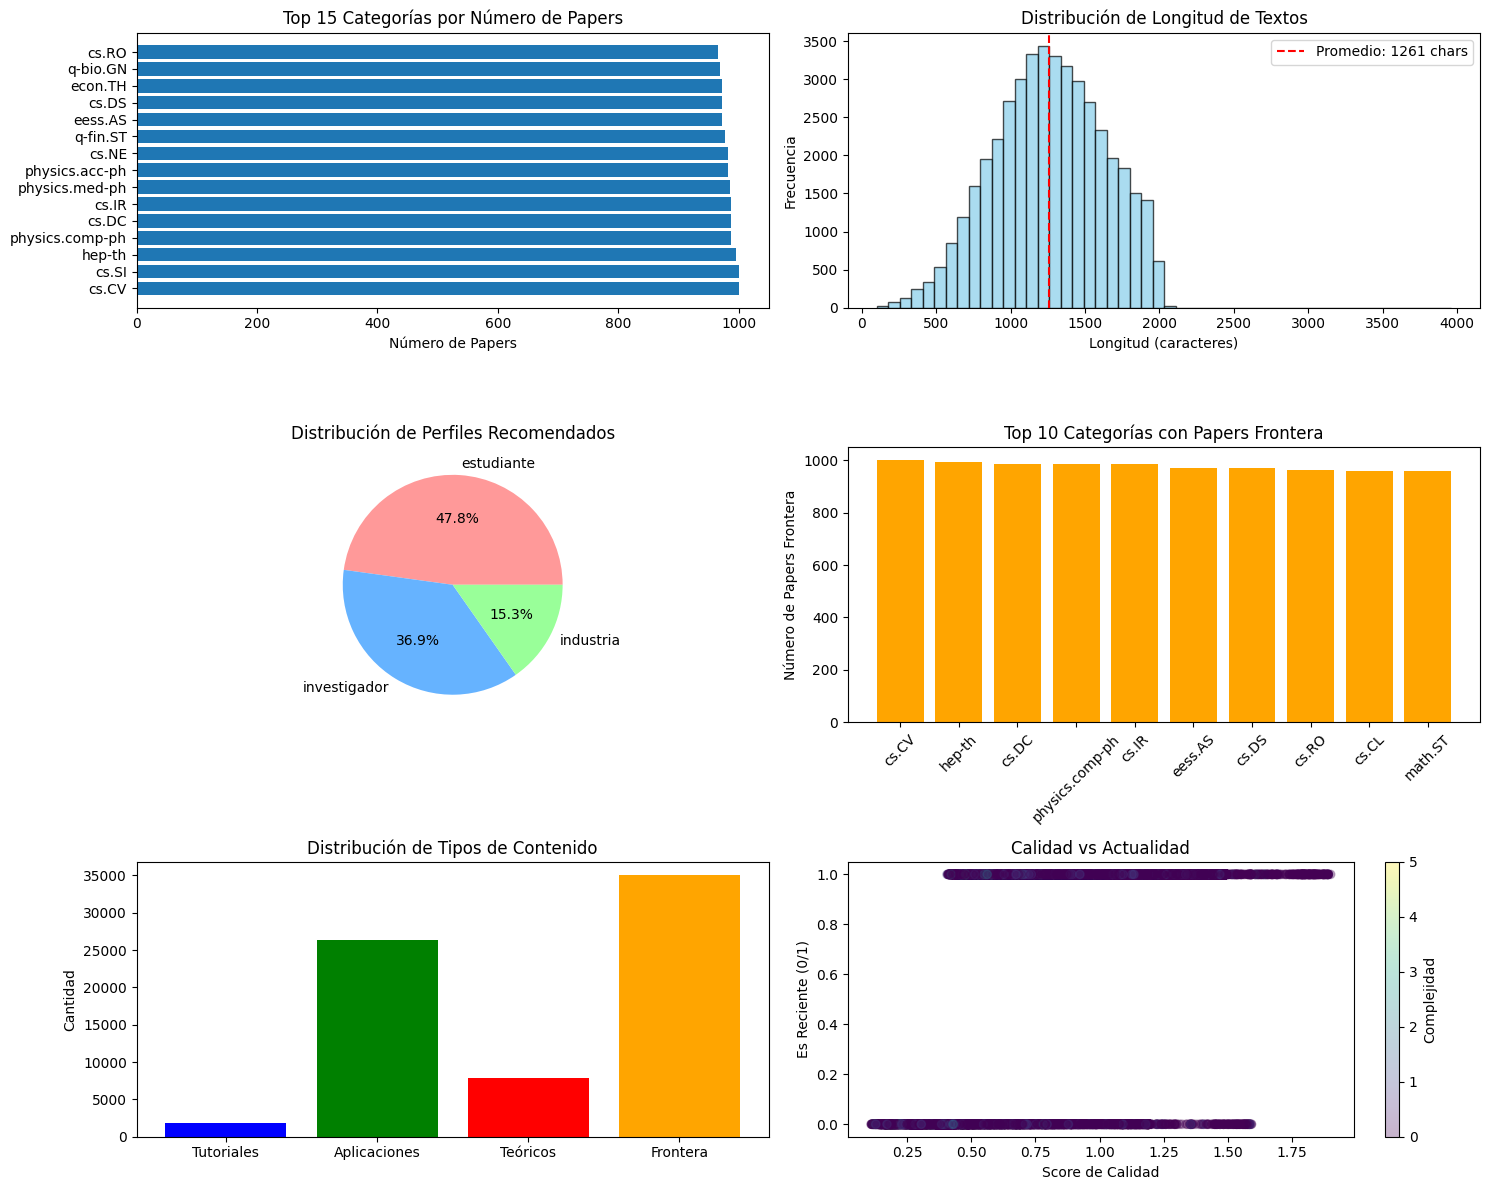


📊 ESTADÍSTICAS DETALLADAS:
   Longitud de texto:
     Mínimo: 101 caracteres
     Máximo: 3962 caracteres
     Promedio: 1261 caracteres
     Mediana: 1262 caracteres

   Distribución de contenido:
     Tutoriales: 1,866
     Aplicaciones: 26,380
     Teóricos: 7,818
     Frontera: 35,064

🎯 ANÁLISIS DE DOMINIOS TEMÁTICOS:
   Papers por dominio temático:
     • machine_learning: 31,389 papers
     • computer_vision: 8,694 papers
     • nlp: 11,387 papers
     • robotics: 7,791 papers
     • theory: 16,653 papers
     • applications: 28,046 papers
     • physics: 12,129 papers
     • math: 14,600 papers
   📚 Papers multidisciplinarios: 37,400

💾 GUARDANDO DATOS PROCESADOS...
✅ Archivos guardados:
   • CSV: arxiv_procesado_completo_43453_papers_20251129_213411.csv
   • Parquet: arxiv_procesado_completo_43453_papers_20251129_212437.parquet

🎉 PREPROCESAMIENTO COMPLETADO - RESUMEN EJECUTIVO
📊 DATASET FINAL:
   • Papers procesados: 43,453
   • Categorías únicas: 47
   • Columnas generadas:

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Descargar recursos de NLTK solo si es necesario
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print(" CARGANDO DATASET MEJORADO")
df = pd.read_csv('arxiv_turbo_mejorado_43453_papers_20251129_211438.csv')  
print(f" Dataset cargado: {len(df):,} papers")
print(f" Columnas disponibles: {list(df.columns)}")

def preprocesamiento_avanzado_optimizado(df):
    """
    Preprocesamiento COMPLETO pero OPTIMIZADO para el modelo transformer
    """
    print("\n INICIANDO PREPROCESAMIENTO AVANZADO OPTIMIZADO...")
    
    df_procesado = df.copy()
    
    # 1. LIMPIEZA DE TEXTO AVANZADA (optimizada para velocidad)
    def limpiar_texto_avanzado(texto):
        if pd.isna(texto):
            return ""
        
        # Convertir a minúsculas
        texto = texto.lower()
        
        # Eliminar URLs, emails y caracteres especiales MÁS EFICIENTE
        texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
        texto = re.sub(r'\S*@\S*\s?', '', texto)
        texto = re.sub(r'[^a-zA-Z\s]', ' ', texto)
        
        # Eliminar espacios extras
        texto = re.sub(r'\s+', ' ', texto).strip()
        
        return texto
    
    print("📝 Procesando textos...")
    df_procesado['abstract_clean'] = df_procesado['abstract'].apply(limpiar_texto_avanzado)
    df_procesado['title_clean'] = df_procesado['title'].apply(limpiar_texto_avanzado)
    
    # 2. COMBINAR TEXTO PARA EL MODELO
    df_procesado['texto_completo'] = (
        df_procesado['title_clean'] + " [SEP] " + df_procesado['abstract_clean']
    )
    
    # 3. FILTRAR TEXTOS VACÍOS (raro pero por si acaso)
    textos_vacios = df_procesado['texto_completo'].str.strip().eq('').sum()
    if textos_vacios > 0:
        print(f"⚠️  Eliminando {textos_vacios} textos vacíos...")
        df_procesado = df_procesado[df_procesado['texto_completo'].str.strip() != '']
    
    # 4. CODIFICAR CATEGORÍAS PRINCIPALES
    print("🏷️  Codificando categorías...")
    le = LabelEncoder()
    df_procesado['category_encoded'] = le.fit_transform(df_procesado['category'])
    
    # 5. CALCULAR MÉTRICAS DE TEXTO AVANZADAS
    print("📊 Calculando métricas de texto...")
    df_procesado['text_length'] = df_procesado['texto_completo'].str.len()
    df_procesado['word_count'] = df_procesado['texto_completo'].str.split().str.len()
    
    # 6. DETECCIÓN DE DOMINIO/TEMA PRINCIPAL (MEJORADO)
    print("🎯 Analizando temas principales...")
    
    # Palabras clave por dominio (expandido)
    domain_keywords = {
        'machine_learning': ['learning', 'neural', 'network', 'deep', 'model', 'training', 'algorithm'],
        'computer_vision': ['image', 'vision', 'recognition', 'detection', 'visual', 'pixel', 'convolutional'],
        'nlp': ['language', 'text', 'nlp', 'transformer', 'bert', 'gpt', 'token', 'embedding'],
        'robotics': ['robot', 'robotics', 'motion', 'control', 'manipulation', 'autonomous'],
        'theory': ['theory', 'theoretical', 'proof', 'mathematical', 'analysis', 'formal'],
        'applications': ['application', 'system', 'framework', 'tool', 'practical', 'implementation'],
        'physics': ['quantum', 'physics', 'particle', 'energy', 'field', 'mechanics'],
        'math': ['mathematical', 'equation', 'function', 'optimization', 'algebra', 'calculus']
    }
    
    for domain, keywords in domain_keywords.items():
        df_procesado[f'domain_{domain}'] = df_procesado['texto_completo'].apply(
            lambda x: sum(1 for keyword in keywords if keyword in x)
        )
    
    # 7. SCORE DE COMPLEJIDAD (MEJORADO)
    complexity_indicators = ['proof', 'theorem', 'equation', 'derivation', 'mathematical', 'formal']
    df_procesado['complexity_score'] = df_procesado['texto_completo'].apply(
        lambda x: sum(1 for indicator in complexity_indicators if indicator in x)
    )
    
    # 8. DETECCIÓN DE PAPERS "FRONTERA" (INNOVADORES)
    print("🚀 Identificando papers frontera...")
    
    # Métrica simple pero efectiva: papers con términos novedosos
    frontier_terms = ['novel', 'new approach', 'first', 'innovative', 'breakthrough', 'state-of-the-art', 'sota']
    df_procesado['frontier_score'] = df_procesado['texto_completo'].apply(
        lambda x: sum(1 for term in frontier_terms if term in x)
    )
    
    # Combinar con métricas existentes para score frontera
    df_procesado['is_frontier'] = (
        (df_procesado['frontier_score'] > 1) |
        (df_procesado['is_recent'] == 1) |
        (df_procesado['complexity_score'] > 2)
    ).astype(int)
    
    # 9. ENRIQUECER METADATOS EXISTENTES
    print("📈 Mejorando metadatos...")
    
    # Score de relevancia por perfil (MEJORADO)
    df_procesado['score_estudiante'] = (
        df_procesado['is_tutorial'] * 3 +
        df_procesado['is_application'] * 2 +
        df_procesado['domain_applications'] * 1 +
        (10 - df_procesado['complexity_score'].clip(0, 10)) * 0.5
    )
    
    df_procesado['score_investigador'] = (
        df_procesado['is_theoretical'] * 2 +
        df_procesado['complexity_score'] * 1.5 +
        df_procesado['is_frontier'] * 3 +
        df_procesado['quality_score'] * 2
    )
    
    df_procesado['score_industria'] = (
        df_procesado['is_application'] * 3 +
        df_procesado['domain_applications'] * 2 +
        df_procesado['is_recent'] * 1.5 +
        df_procesado['quality_score'] * 1
    )
    
    # 10. NORMALIZAR SCORES
    for score_col in ['score_estudiante', 'score_investigador', 'score_industria']:
        df_procesado[score_col] = (
            df_procesado[score_col] - df_procesado[score_col].min()
        ) / (df_procesado[score_col].max() - df_procesado[score_col].min())
    
    # 11. ETIQUETA FINAL DE PERFIL RECOMENDADO (MEJORADA)
    def determinar_perfil_optimo(fila):
        scores = {
            'estudiante': fila['score_estudiante'],
            'investigador': fila['score_investigador'], 
            'industria': fila['score_industria']
        }
        return max(scores.items(), key=lambda x: x[1])[0]
    
    df_procesado['perfil_recomendado'] = df_procesado.apply(determinar_perfil_optimo, axis=1)
    
    # ESTADÍSTICAS FINALES DEL PREPROCESAMIENTO
    print(f"\n✅ PREPROCESAMIENTO COMPLETADO:")
    print(f"   📊 Papers procesados: {len(df_procesado):,}")
    print(f"   🏷️  Categorías únicas: {len(le.classes_)}")
    print(f"   📏 Longitud promedio: {df_procesado['text_length'].mean():.0f} caracteres")
    print(f"   📝 Palabras promedio: {df_procesado['word_count'].mean():.0f}")
    print(f"   🚀 Papers frontera: {df_procesado['is_frontier'].sum():,}")
    print(f"   👥 Distribución de perfiles:")
    perfiles = df_procesado['perfil_recomendado'].value_counts()
    for perfil, count in perfiles.items():
        print(f"      • {perfil}: {count:,} ({(count/len(df_procesado))*100:.1f}%)")
    
    return df_procesado, le

# EJECUTAR PREPROCESAMIENTO
df_procesado, label_encoder = preprocesamiento_avanzado_optimizado(df)

# VISUALIZACIONES MEJORADAS
def crear_visualizaciones_completas(df_procesado):
    """
    Crear visualizaciones para entender mejor los datos
    """
    print("\n📈 CREANDO VISUALIZACIONES...")
    
    plt.figure(figsize=(15, 12))
    
    # 1. Distribución de categorías (top 15)
    plt.subplot(3, 2, 1)
    top_categories = df_procesado['category'].value_counts().head(15)
    plt.barh(range(len(top_categories)), top_categories.values)
    plt.yticks(range(len(top_categories)), top_categories.index)
    plt.title('Top 15 Categorías por Número de Papers')
    plt.xlabel('Número de Papers')
    
    # 2. Distribución de longitud de textos
    plt.subplot(3, 2, 2)
    longitudes = df_procesado['text_length']
    plt.hist(longitudes, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(longitudes.mean(), color='red', linestyle='--', 
                label=f'Promedio: {longitudes.mean():.0f} chars')
    plt.title('Distribución de Longitud de Textos')
    plt.xlabel('Longitud (caracteres)')
    plt.ylabel('Frecuencia')
    plt.legend()
    
    # 3. Distribución de perfiles recomendados
    plt.subplot(3, 2, 3)
    perfiles = df_procesado['perfil_recomendado'].value_counts()
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    plt.pie(perfiles.values, labels=perfiles.index, autopct='%1.1f%%', colors=colors)
    plt.title('Distribución de Perfiles Recomendados')
    
    # 4. Papers frontera por categoría
    plt.subplot(3, 2, 4)
    frontier_by_category = df_procesado[df_procesado['is_frontier'] == 1]['category'].value_counts().head(10)
    plt.bar(range(len(frontier_by_category)), frontier_by_category.values, color='orange')
    plt.xticks(range(len(frontier_by_category)), frontier_by_category.index, rotation=45)
    plt.title('Top 10 Categorías con Papers Frontera')
    plt.ylabel('Número de Papers Frontera')
    
    # 5. Distribución de tipos de contenido
    plt.subplot(3, 2, 5)
    tipos = ['Tutoriales', 'Aplicaciones', 'Teóricos', 'Frontera']
    counts = [
        df_procesado['is_tutorial'].sum(),
        df_procesado['is_application'].sum(), 
        df_procesado['is_theoretical'].sum(),
        df_procesado['is_frontier'].sum()
    ]
    plt.bar(tipos, counts, color=['blue', 'green', 'red', 'orange'])
    plt.title('Distribución de Tipos de Contenido')
    plt.ylabel('Cantidad')
    
    # 6. Calidad vs Actualidad
    plt.subplot(3, 2, 6)
    plt.scatter(df_procesado['quality_score'], df_procesado['is_recent'], 
                alpha=0.3, c=df_procesado['complexity_score'], cmap='viridis')
    plt.xlabel('Score de Calidad')
    plt.ylabel('Es Reciente (0/1)')
    plt.title('Calidad vs Actualidad')
    plt.colorbar(label='Complejidad')
    
    plt.tight_layout()
    plt.show()
    
    # ESTADÍSTICAS NUMÉRICAS
    print(f"\n📊 ESTADÍSTICAS DETALLADAS:")
    print(f"   Longitud de texto:")
    print(f"     Mínimo: {df_procesado['text_length'].min()} caracteres")
    print(f"     Máximo: {df_procesado['text_length'].max()} caracteres") 
    print(f"     Promedio: {df_procesado['text_length'].mean():.0f} caracteres")
    print(f"     Mediana: {df_procesado['text_length'].median():.0f} caracteres")
    
    print(f"\n   Distribución de contenido:")
    print(f"     Tutoriales: {df_procesado['is_tutorial'].sum():,}")
    print(f"     Aplicaciones: {df_procesado['is_application'].sum():,}")
    print(f"     Teóricos: {df_procesado['is_theoretical'].sum():,}")
    print(f"     Frontera: {df_procesado['is_frontier'].sum():,}")

# EJECUTAR VISUALIZACIONES
crear_visualizaciones_completas(df_procesado)

# ANÁLISIS DE DOMINIOS/TEMAS
def analizar_dominios_tematicos(df_procesado):
    """
    Análisis profundo de los dominios temáticos detectados
    """
    print("\n🎯 ANÁLISIS DE DOMINIOS TEMÁTICOS:")
    
    domain_columns = [col for col in df_procesado.columns if col.startswith('domain_')]
    
    print("   Papers por dominio temático:")
    for domain_col in domain_columns:
        domain_name = domain_col.replace('domain_', '')
        count = (df_procesado[domain_col] > 0).sum()
        print(f"     • {domain_name}: {count:,} papers")
    
    # Encontrar papers multidisciplinarios
    df_procesado['num_dominios'] = df_procesado[domain_columns].gt(0).sum(axis=1)
    multidisciplinarios = (df_procesado['num_dominios'] > 1).sum()
    print(f"   📚 Papers multidisciplinarios: {multidisciplinarios:,}")
    
    return df_procesado

df_procesado = analizar_dominios_tematicos(df_procesado)

# GUARDAR DATOS PROCESADOS
print("\n💾 GUARDANDO DATOS PROCESADOS...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_procesado = f"arxiv_procesado_completo_{len(df_procesado)}_papers_{timestamp}.csv"
df_procesado.to_csv(filename_procesado, index=False)

# GUARDAR TAMBIÉN EN FORMATO PARQUET (más eficiente)

print("✅ Archivos guardados:")
print(f"   • CSV: {filename_procesado}")

# RESUMEN EJECUTIVO FINAL
print(f"\n🎉 PREPROCESAMIENTO COMPLETADO - RESUMEN EJECUTIVO")
print("=" * 60)
print(f"📊 DATASET FINAL:")
print(f"   • Papers procesados: {len(df_procesado):,}")
print(f"   • Categorías únicas: {df_procesado['category'].nunique()}")
print(f"   • Columnas generadas: {len(df_procesado.columns)}")

print(f"\n🎯 CARACTERÍSTICAS PARA EL MODELO:")
print(f"   • Texto para embeddings: 'texto_completo'")
print(f"   • Categorías codificadas: 'category_encoded'")
print(f"   • Perfiles recomendados: 'perfil_recomendado'")
print(f"   • Papers frontera: 'is_frontier'")

print(f"\n📈 MÉTRICAS CLAVE:")
print(f"   👥 Perfiles:")
perfiles = df_procesado['perfil_recomendado'].value_counts()
for perfil, count in perfiles.items():
    print(f"      {perfil.capitalize()}: {count:,} papers")

print(f"   🎪 Tipos de contenido:")
print(f"      Tutoriales: {df_procesado['is_tutorial'].sum():,}")
print(f"      Aplicaciones: {df_procesado['is_application'].sum():,}") 
print(f"      Teóricos: {df_procesado['is_theoretical'].sum():,}")
print(f"      Frontera: {df_procesado['is_frontier'].sum():,}")

print(f"\n🚀 LISTO PARA EL SIGUIENTE PASO:")
print(f"   • Entrenamiento del modelo transformer")
print(f"   • Generación de embeddings semánticos")
print(f"   • Sistema de recomendación personalizado")

# EJEMPLOS DE DIFERENTES TIPOS PARA DEMOSTRACIÓN
print(f"\n🔍 EJEMPLOS PARA DEMOSTRACIÓN:")
print(f"🎓 PAPER PARA ESTUDIANTE:")
ejemplo_est = df_procesado[df_procesado['perfil_recomendado'] == 'estudiante'].iloc[0]
print(f"   '{ejemplo_est['title'][:80]}...'")
print(f"   📊 [Tutorial: {ejemplo_est['is_tutorial']}, App: {ejemplo_est['is_application']}, Complejidad: {ejemplo_est['complexity_score']}]")

print(f"🔬 PAPER PARA INVESTIGADOR:")
ejemplo_inv = df_procesado[df_procesado['perfil_recomendado'] == 'investigador'].iloc[0]
print(f"   '{ejemplo_inv['title'][:80]}...'")
print(f"   📊 [Teórico: {ejemplo_inv['is_theoretical']}, Frontera: {ejemplo_inv['is_frontier']}, Calidad: {ejemplo_inv['quality_score']:.2f}]")

print(f"🏭 PAPER PARA INDUSTRIA:")
ejemplo_ind = df_procesado[df_procesado['perfil_recomendado'] == 'industria'].iloc[0]
print(f"   '{ejemplo_ind['title'][:80]}...'")
print(f"   📊 [Aplicación: {ejemplo_ind['is_application']}, Reciente: {ejemplo_ind['is_recent']}, Calidad: {ejemplo_ind['quality_score']:.2f}]")

# Graficas

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo PROFESIONAL
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def crear_visualizaciones_profesionales(df):
    """
    Crea visualizaciones MODERNAS y UTILES para el análisis de papers
    """
    print("🎨 CREANDO VISUALIZACIONES PROFESIONALES...")
    
    # Crear figura principal
    fig = plt.figure(figsize=(20, 16))
    
    # 1. 📈 TOP CATEGORÍAS MÁS INVESTIGADAS (Horizontal Bar Chart)
    plt.subplot(3, 3, 1)
    top_categories = df['category'].value_counts().head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_categories)))
    
    bars = plt.barh(range(len(top_categories)), top_categories.values, color=colors, alpha=0.8)
    plt.yticks(range(len(top_categories)), top_categories.index, fontsize=9)
    plt.xlabel('Número de Papers', fontsize=11, fontweight='bold')
    plt.title('🔬 TOP 15 CATEGORÍAS MÁS INVESTIGADAS', fontsize=13, fontweight='bold', pad=20)
    
    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=8, fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    # 2. 🎯 DISTRIBUCIÓN DE PERFILES DE USUARIO (Pie Chart mejorado)
    plt.subplot(3, 3, 2)
    perfiles = df['perfil_recomendado'].value_counts()
    
    # Colores específicos para cada perfil
    profile_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    explode = (0.05, 0.05, 0.05)  # Separar ligeramente las secciones
    
    wedges, texts, autotexts = plt.pie(perfiles.values, labels=perfiles.index, 
                                      autopct='%1.1f%%', startangle=90,
                                      colors=profile_colors, explode=explode,
                                      textprops={'fontsize': 10, 'fontweight': 'bold'})
    
    # Mejorar los textos automáticos
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.title('👥 DISTRIBUCIÓN DE PERFILES RECOMENDADOS', fontsize=13, fontweight='bold', pad=20)
    
    # 3. 📊 EVOLUCIÓN TEMPORAL DE PUBLICACIONES (Line Chart)
    plt.subplot(3, 3, 3)
    if 'published' in df.columns:
        df_temp = df.copy()
        df_temp['published'] = pd.to_datetime(df_temp['published'])
        df_temp['year'] = df_temp['published'].dt.year
        papers_por_año = df_temp['year'].value_counts().sort_index()
        
        plt.plot(papers_por_año.index, papers_por_año.values, 
                marker='o', linewidth=3, markersize=6, color='#FF6B6B', alpha=0.8)
        plt.fill_between(papers_por_año.index, papers_por_año.values, alpha=0.2, color='#FF6B6B')
        
        plt.xlabel('Año', fontweight='bold')
        plt.ylabel('Número de Papers', fontweight='bold')
        plt.title('📅 EVOLUCIÓN DE PUBLICACIONES POR AÑO', fontsize=13, fontweight='bold', pad=20)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
    
    # 4. 🔥 PAPERS FRONTERA POR CATEGORÍA (Heatmap Style)
    plt.subplot(3, 3, 4)
    if 'is_frontier' in df.columns:
        frontier_by_cat = df[df['is_frontier'] == 1]['category'].value_counts().head(10)
        
        y_pos = np.arange(len(frontier_by_cat))
        colors = plt.cm.plasma(np.linspace(0, 1, len(frontier_by_cat)))
        
        bars = plt.barh(y_pos, frontier_by_cat.values, color=colors, alpha=0.8)
        plt.yticks(y_pos, frontier_by_cat.index, fontsize=9)
        plt.xlabel('Número de Papers Frontera', fontweight='bold')
        plt.title('🚀 TOP 10 CATEGORÍAS CON PAPERS FRONTERA', fontsize=13, fontweight='bold', pad=20)
        
        # Añadir valores
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center', fontsize=9, fontweight='bold')
        
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
    
    # 5. 📚 DISTRIBUCIÓN DE TIPOS DE CONTENIDO (Stacked Bar)
    plt.subplot(3, 3, 5)
    tipos_contenido = ['Tutoriales', 'Aplicaciones', 'Teóricos', 'Frontera']
    counts = [
        df['is_tutorial'].sum() if 'is_tutorial' in df.columns else 0,
        df['is_application'].sum() if 'is_application' in df.columns else 0,
        df['is_theoretical'].sum() if 'is_theoretical' in df.columns else 0,
        df['is_frontier'].sum() if 'is_frontier' in df.columns else 0
    ]
    
    colors = ['#FFD166', '#06D6A0', '#118AB2', '#EF476F']
    bars = plt.bar(tipos_contenido, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    plt.ylabel('Cantidad de Papers', fontweight='bold')
    plt.title('📊 DISTRIBUCIÓN DE TIPOS DE CONTENIDO', fontsize=13, fontweight='bold', pad=20)
    plt.xticks(rotation=15, ha='right')
    
    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    
    # 6. 🎪 CALIDAD vs ACTUALIDAD (Scatter Plot mejorado)
    plt.subplot(3, 3, 6)
    if 'quality_score' in df.columns and 'is_recent' in df.columns:
        # Crear categorías de calidad
        quality_bins = pd.cut(df['quality_score'], bins=5, labels=['Muy Baja', 'Baja', 'Media', 'Alta', 'Muy Alta'])
        
        scatter = plt.scatter(df['quality_score'], df['is_recent'], 
                             c=df['complexity_score'] if 'complexity_score' in df.columns else df['quality_score'],
                             cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        plt.xlabel('Score de Calidad', fontweight='bold')
        plt.ylabel('Es Reciente (0 = No, 1 = Sí)', fontweight='bold')
        plt.title('🎯 RELACIÓN: CALIDAD vs ACTUALIDAD', fontsize=13, fontweight='bold', pad=20)
        plt.colorbar(scatter, label='Complejidad' if 'complexity_score' in df.columns else 'Calidad')
        plt.grid(True, alpha=0.3)
    
    # 7. 📏 DISTRIBUCIÓN DE LONGITUD DE TEXTOS (Violin Plot + Box Plot)
    plt.subplot(3, 3, 7)
    if 'text_length' in df.columns:
        # Eliminar outliers extremos para mejor visualización
        Q1 = df['text_length'].quantile(0.25)
        Q3 = df['text_length'].quantile(0.75)
        IQR = Q3 - Q1
        df_filtered = df[(df['text_length'] >= Q1 - 1.5*IQR) & (df['text_length'] <= Q3 + 1.5*IQR)]
        
        parts = plt.violinplot(df_filtered['text_length'], showmeans=True, showmedians=True)
        
        # Personalizar el violin plot
        for pc in parts['bodies']:
            pc.set_facecolor('#1f77b4')
            pc.set_alpha(0.7)
        
        plt.ylabel('Longitud (caracteres)', fontweight='bold')
        plt.title('📏 DISTRIBUCIÓN DE LONGITUD DE TEXTOS', fontsize=13, fontweight='bold', pad=20)
        plt.grid(True, alpha=0.3)
    
    # 8. 🌐 DOMINIOS TEMÁTICOS MÁS POPULARES (Radar Chart - versión simplificada)
    plt.subplot(3, 3, 8)
    domain_columns = [col for col in df.columns if col.startswith('domain_')]
    if domain_columns:
        domain_counts = []
        domain_names = []
        
        for domain_col in domain_columns[:8]:  # Tomar máximo 8 dominios
            domain_name = domain_col.replace('domain_', '').replace('_', ' ').title()
            count = (df[domain_col] > 0).sum()
            domain_counts.append(count)
            domain_names.append(domain_name)
        
        # Gráfico de barras en lugar de radar para mayor claridad
        y_pos = np.arange(len(domain_names))
        colors = plt.cm.Set3(np.linspace(0, 1, len(domain_names)))
        
        bars = plt.barh(y_pos, domain_counts, color=colors, alpha=0.8)
        plt.yticks(y_pos, domain_names, fontsize=9)
        plt.xlabel('Número de Papers', fontweight='bold')
        plt.title('🌐 DOMINIOS TEMÁTICOS MÁS POPULARES', fontsize=13, fontweight='bold', pad=20)
        
        # Añadir valores
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                    f'{int(width):,}', ha='left', va='center', fontsize=8, fontweight='bold')
        
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
    
    # 9. 📈 COMPARATIVA PERFILES vs TIPOS DE CONTENIDO (Heatmap)
    plt.subplot(3, 3, 9)
    try:
        # Crear matriz de correlación entre perfiles y tipos de contenido
        profile_dummies = pd.get_dummies(df['perfil_recomendado'])
        content_types = df[['is_tutorial', 'is_application', 'is_theoretical', 'is_frontier']]
        
        # Calcular correlaciones
        correlation_matrix = pd.concat([profile_dummies, content_types], axis=1).corr()
        profile_content_corr = correlation_matrix.loc[profile_dummies.columns, content_types.columns]
        
        # Heatmap
        sns.heatmap(profile_content_corr, annot=True, cmap='RdYlBu', center=0,
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('📈 CORRELACIÓN: PERFILES vs TIPOS DE CONTENIDO', 
                 fontsize=13, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
    except Exception as e:
        # Fallback: gráfico de densidad de calidad
        if 'quality_score' in df.columns:
            df['quality_score'].plot(kind='density', color='purple', alpha=0.7, linewidth=2)
            plt.xlabel('Score de Calidad', fontweight='bold')
            plt.ylabel('Densidad', fontweight='bold')
            plt.title('📊 DISTRIBUCIÓN DE SCORES DE CALIDAD', fontsize=13, fontweight='bold', pad=20)
            plt.grid(True, alpha=0.3)
            plt.fill_between(df['quality_score'].value_counts().sort_index().index, 
                           df['quality_score'].value_counts().sort_index().values, alpha=0.3, color='purple')
    
    # Ajustar layout
    plt.tight_layout(pad=4.0)
    
    # Añadir título general
    fig.suptitle('📊 ANÁLISIS VISUAL COMPLETO - SISTEMA DE RECOMENDACIÓN ACADÉMICA', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Guardar la figura
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"analisis_visual_profesional_{timestamp}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    
    print(f"💾 Gráfica guardada como: {filename}")
    
    # ESTADÍSTICAS RESUMEN
    print(f"\n📈 ESTADÍSTICAS CLAVE DEL DATASET:")
    print(f"   • Total de papers: {len(df):,}")
    print(f"   • Categorías únicas: {df['category'].nunique()}")
    print(f"   • Papers recientes (<1 año): {df['is_recent'].sum() if 'is_recent' in df.columns else 'N/A':,}")
    print(f"   • Papers frontera: {df['is_frontier'].sum() if 'is_frontier' in df.columns else 'N/A':,}")
    
    if 'perfil_recomendado' in df.columns:
        print(f"   • Distribución de perfiles:")
        for perfil, count in df['perfil_recomendado'].value_counts().items():
            print(f"     - {perfil}: {count:,} ({(count/len(df))*100:.1f}%)")

# FUNCIÓN ADICIONAL: Gráfica de tendencias temporales por categoría
def crear_tendencias_temporales(df):
    """
    Crea gráficas de tendencias temporales por categoría principal
    """
    if 'published' not in df.columns:
        print("⚠️  No hay datos de fecha para análisis temporal")
        return
    
    print("\n📅 ANALIZANDO TENDENCIAS TEMPORALES...")
    
    df_temp = df.copy()
    df_temp['published'] = pd.to_datetime(df_temp['published'])
    df_temp['year'] = df_temp['published'].dt.year
    
    # Top 6 categorías para análisis
    top_categories = df_temp['category'].value_counts().head(6).index
    
    plt.figure(figsize=(15, 10))
    
    for i, category in enumerate(top_categories, 1):
        plt.subplot(2, 3, i)
        
        # Datos por año para esta categoría
        cat_data = df_temp[df_temp['category'] == category]
        papers_por_año = cat_data['year'].value_counts().sort_index()
        
        plt.plot(papers_por_año.index, papers_por_año.values, 
                marker='o', linewidth=2, markersize=4, label=category)
        plt.fill_between(papers_por_año.index, papers_por_año.values, alpha=0.2)
        
        plt.title(f'{category}', fontweight='bold')
        plt.xlabel('Año')
        plt.ylabel('Número de Papers')
        plt.grid(True, alpha=0.3)
        
        # Rotar años si hay muchos
        if len(papers_por_año) > 5:
            plt.xticks(rotation=45)
    
    plt.tight_layout(pad=3.0)
    plt.suptitle('📈 TENDENCIAS TEMPORALES POR CATEGORÍA PRINCIPAL', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Guardar
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"tendencias_temporales_{timestamp}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"💾 Tendencias guardadas como: {filename}")

# FUNCIÓN ADICIONAL: Análisis de autores más productivos
def analizar_autores_productivos(df, top_n=15):
    """
    Analiza los autores más productivos en el dataset
    """
    print(f"\n👨‍🎓 ANALIZANDO AUTORES MÁS PRODUCTIVOS (Top {top_n})...")
    
    if 'authors' not in df.columns:
        print("⚠️  No hay datos de autores")
        return
    
    # Procesar autores (asumiendo que están separados por ';')
    all_authors = []
    for authors_str in df['authors'].dropna():
        if ';' in str(authors_str):
            all_authors.extend([author.strip() for author in authors_str.split(';')])
        else:
            all_authors.append(str(authors_str).strip())
    
    author_counts = pd.Series(all_authors).value_counts().head(top_n)
    
    plt.figure(figsize=(12, 8))
    
    # Gráfica de autores más productivos
    colors = plt.cm.plasma(np.linspace(0, 1, len(author_counts)))
    bars = plt.barh(range(len(author_counts)), author_counts.values, color=colors, alpha=0.8)
    
    plt.yticks(range(len(author_counts)), author_counts.index, fontsize=10)
    plt.xlabel('Número de Papers Publicados', fontweight='bold')
    plt.title(f'👑 TOP {top_n} AUTORES MÁS PRODUCTIVOS', fontsize=14, fontweight='bold', pad=20)
    
    # Añadir valores
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    # Guardar
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"autores_productivos_{timestamp}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"💾 Análisis de autores guardado como: {filename}")
    
    # Mostrar estadísticas
    print(f"\n📊 ESTADÍSTICAS DE AUTORES:")
    print(f"   • Total de autores únicos: {len(set(all_authors)):,}")
    print(f"   • Autor más productivo: {author_counts.index[0]} ({author_counts.iloc[0]} papers)")
    print(f"   • Promedio de papers por autor: {len(all_authors)/len(set(all_authors)):.1f}")

# EJECUTAR TODAS LAS VISUALIZACIONES
def ejecutar_analisis_completo(df):
    """
    Ejecuta todo el análisis visual completo
    """
    print("🎨 INICIANDO ANÁLISIS VISUAL COMPLETO...")
    print("=" * 60)
    
    # 1. Visualizaciones principales
    crear_visualizaciones_profesionales(df)
    
    # 2. Tendencias temporales
    crear_tendencias_temporales(df)
    
    # 3. Análisis de autores
    analizar_autores_productivos(df)
    
    print("\n✅ ANÁLISIS VISUAL COMPLETADO!")
    print("📊 Se han generado gráficas profesionales listas para tu presentación")

# USO:
# ejecutar_analisis_completo(df_procesado)

🎨 INICIANDO ANÁLISIS VISUAL COMPLETO...
🎨 CREANDO VISUALIZACIONES PROFESIONALES...


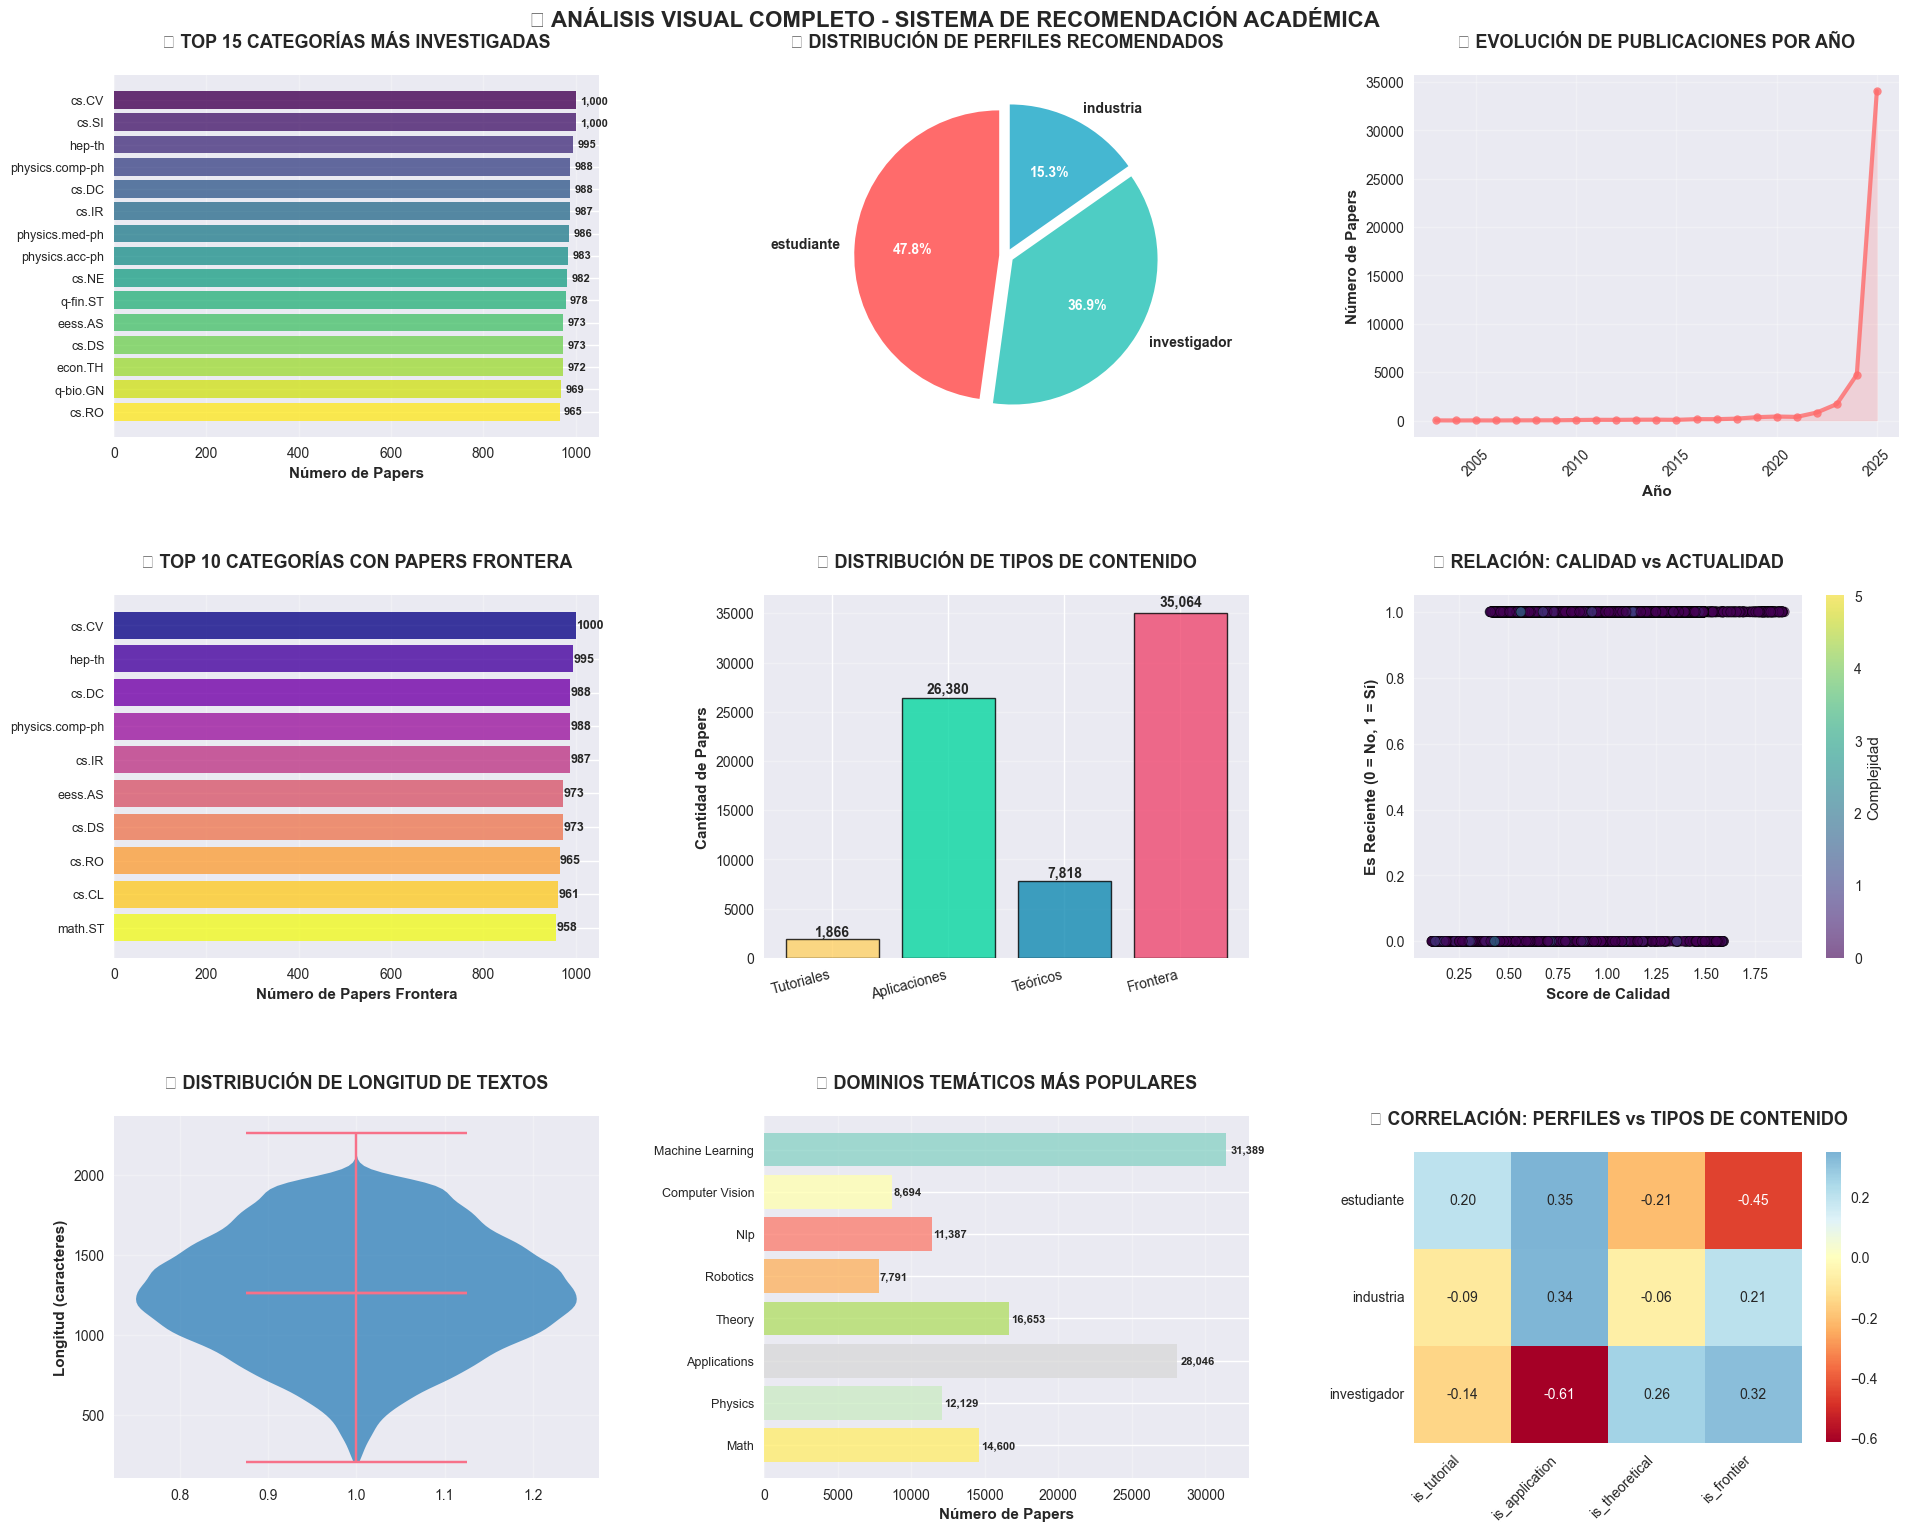

💾 Gráfica guardada como: analisis_visual_profesional_20251129_213651.png

📈 ESTADÍSTICAS CLAVE DEL DATASET:
   • Total de papers: 43,453
   • Categorías únicas: 47
   • Papers recientes (<1 año): 34,738
   • Papers frontera: 35,064
   • Distribución de perfiles:
     - estudiante: 20,784 (47.8%)
     - investigador: 16,038 (36.9%)
     - industria: 6,631 (15.3%)

📅 ANALIZANDO TENDENCIAS TEMPORALES...


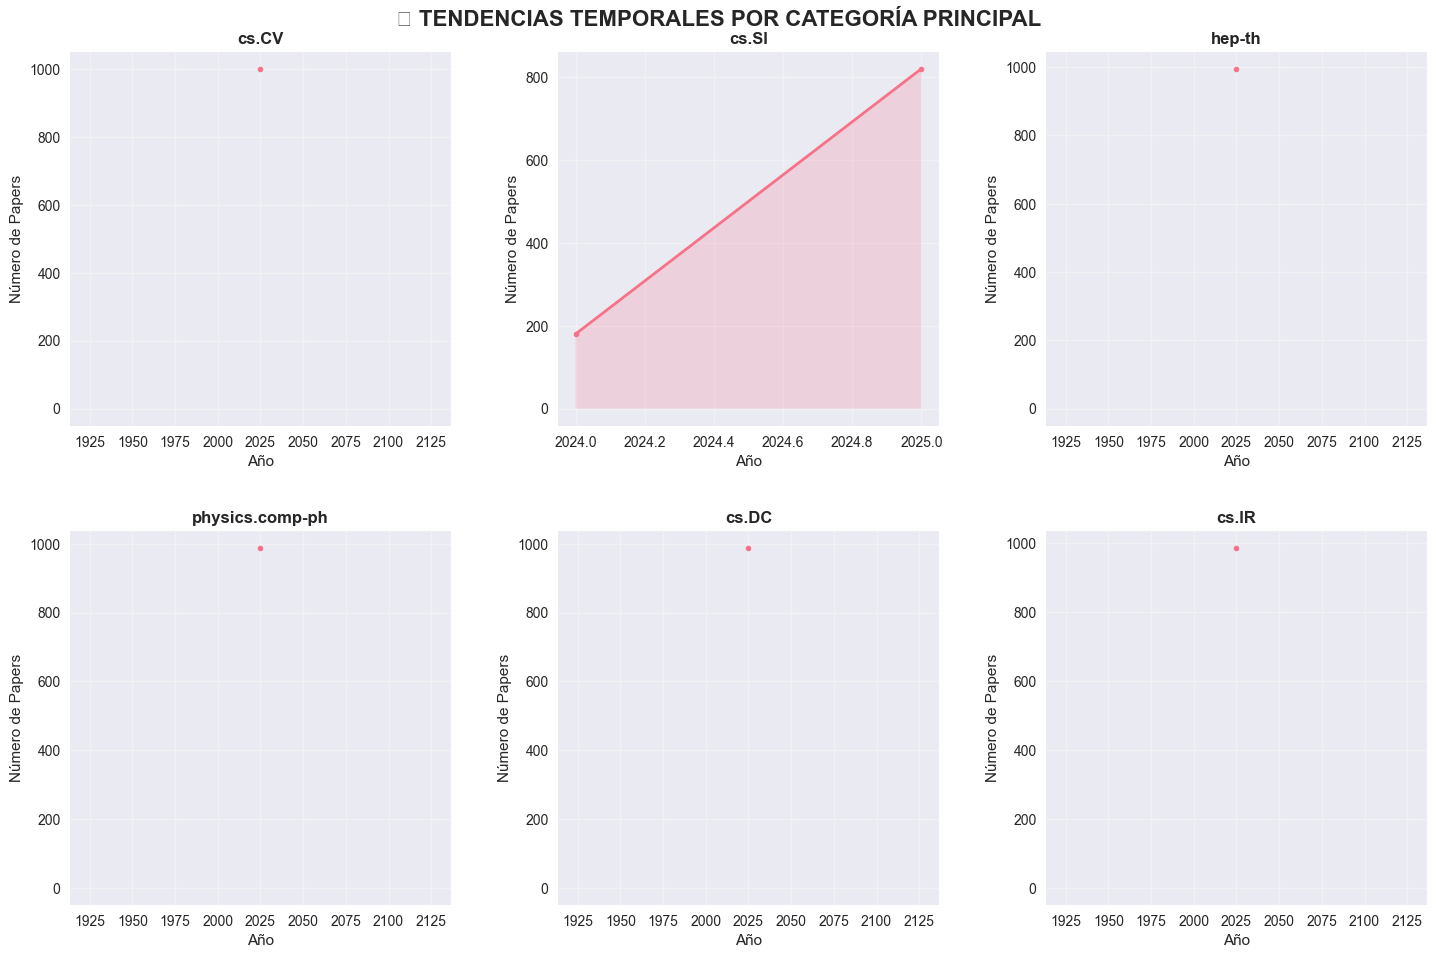

💾 Tendencias guardadas como: tendencias_temporales_20251129_213655.png

👨‍🎓 ANALIZANDO AUTORES MÁS PRODUCTIVOS (Top 15)...


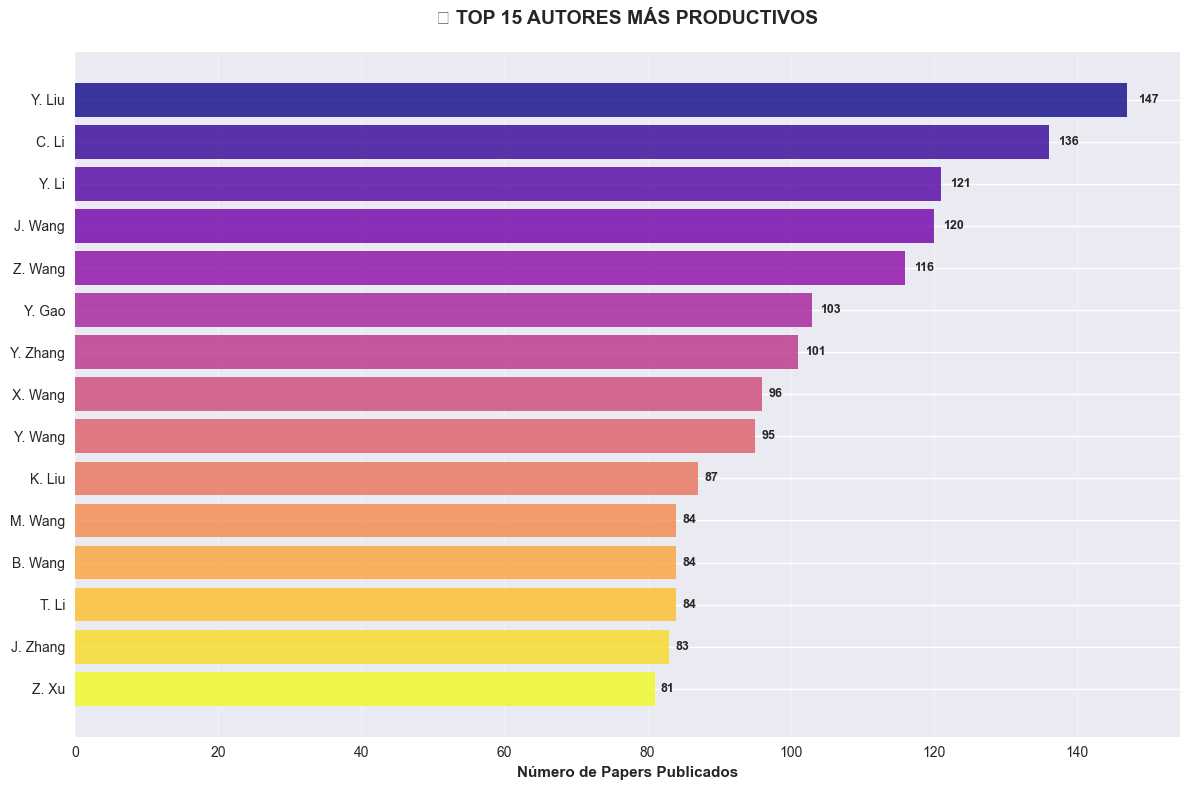

💾 Análisis de autores guardado como: autores_productivos_20251129_213656.png

📊 ESTADÍSTICAS DE AUTORES:
   • Total de autores únicos: 149,273
   • Autor más productivo: Y. Liu (147 papers)
   • Promedio de papers por autor: 1.8

✅ ANÁLISIS VISUAL COMPLETADO!
📊 Se han generado gráficas profesionales listas para tu presentación


In [6]:
ejecutar_analisis_completo(df_procesado)

# Embedings


🎯 INICIANDO GENERACIÓN DE EMBEDDINGS OPTIMIZADA
📚 CARGANDO DATOS PREPROCESADOS...
✅ Dataset cargado: 43,453 papers
📊 Muestra de datos:
   • Categorías: 47
   • Columnas: 46
   • Texto promedio: 1261 caracteres

🔧 INICIALIZANDO GENERADOR OPTIMIZADO...
🔧 INICIALIZANDO GENERADOR DE EMBEDDINGS OPTIMIZADO...
✅ Modelo cargado: all-MiniLM-L6-v2
🎯 Dispositivo: cuda
📊 Dimensión embeddings: 384
⚡ Precisión: FP16

🚀 GENERANDO EMBEDDINGS...
🚀 GENERANDO EMBEDDINGS PARA 43,453 TEXTOS...
   • Batch size: 512
   • Modelo: sentence-transformers/all-MiniLM-L6-v2
   • Dimensión: 384


Batches:   0%|          | 0/85 [00:00<?, ?it/s]

✅ EMBEDDINGS GENERADOS EN 28.6 SEGUNDOS
📊 Velocidad: 1521.6 textos/segundo
🎯 Dimensión final: (43453, 384)

📊 ANALIZANDO CALIDAD...
📊 ANALIZANDO CALIDAD DE EMBEDDINGS...
   📈 Estadísticas básicas:
      • Shape: (43453, 384)
      • Norma promedio: 1.0000
      • Desviación estándar: 0.0510
   🔍 Analizando similitudes semánticas...
      • Similitud intra-clase: 0.2550
      • Similitud inter-clase: 0.0950
      • Separabilidad: 0.1600
      • Densidad intra-clase: 2.12%
   🎨 Generando visualizaciones...
⚠️  Error en análisis de calidad: Too many bins for data range. Cannot create 50 finite-sized bins.
   Continuando sin análisis detallado...

💾 GUARDANDO RESULTADOS...
💾 GUARDANDO EMBEDDINGS: arxiv_embeddings_43453_20251129_221146
✅ Archivos guardados:
   • arxiv_embeddings_43453_20251129_221146.npy (embeddings)
   • arxiv_embeddings_43453_20251129_221146_metadata.csv (metadatos)
   • arxiv_embeddings_43453_20251129_221146_info.json (información)

🎉 GENERACIÓN DE EMBEDDINGS COMPLETADA!

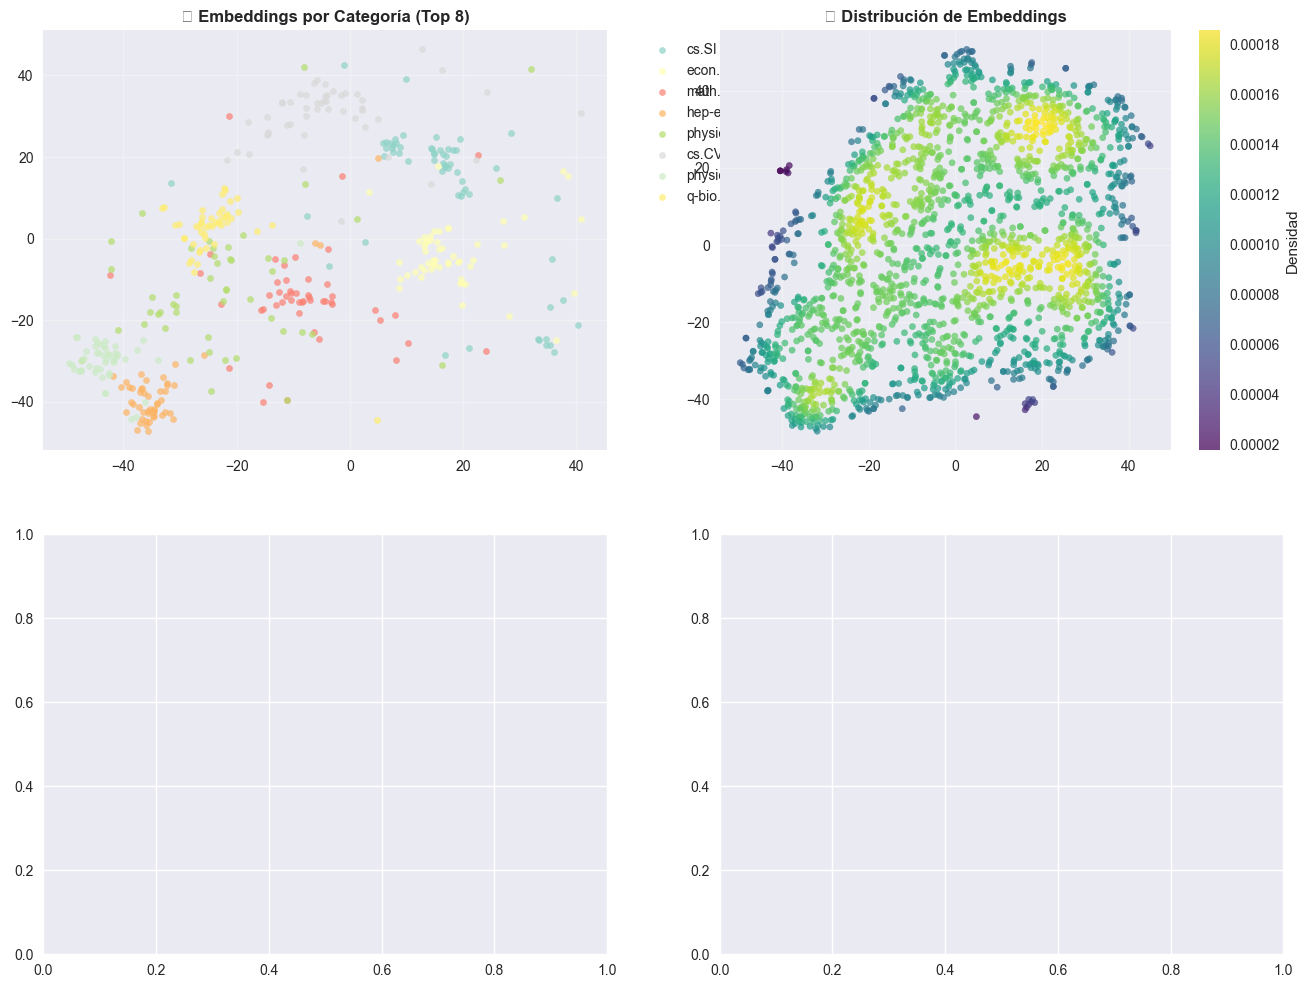

In [11]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
import torch
import os
import glob
import json

class ArXivEmbeddingGenerator:
    """
    VERSIÓN CORREGIDA Y OPTIMIZADA: Generación de embeddings ultra-rápida
    """
    
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        print("🔧 INICIALIZANDO GENERADOR DE EMBEDDINGS OPTIMIZADO...")
        
        # Configuración automática del dispositivo
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Cargar modelo ESPECIALIZADO en embeddings
        self.model = SentenceTransformer(f'sentence-transformers/{model_name}', device=self.device)
        
        # Configuraciones de optimización para GPU
        if self.device == 'cuda':
            self.model = self.model.half()  # FP16 para mayor velocidad
            torch.backends.cudnn.benchmark = True
        
        print(f"✅ Modelo cargado: {model_name}")
        print(f"🎯 Dispositivo: {self.device}")
        print(f"📊 Dimensión embeddings: {self.model.get_sentence_embedding_dimension()}")
        print(f"⚡ Precisión: {'FP16' if self.device == 'cuda' else 'FP32'}")
    
    def generar_embeddings_ultra_rapido(self, textos, batch_size=256, show_progress=True):
        """
        Generación ULTRA RÁPIDA de embeddings
        """
        print(f"🚀 GENERANDO EMBEDDINGS PARA {len(textos):,} TEXTOS...")
        print(f"   • Batch size: {batch_size}")
        print(f"   • Modelo: {self.model._modules['0'].auto_model.config.name_or_path}")
        print(f"   • Dimensión: {self.model.get_sentence_embedding_dimension()}")
        
        start_time = time.time()
        
        embeddings = self.model.encode(
            textos,
            batch_size=batch_size,
            show_progress_bar=show_progress,
            convert_to_tensor=False,
            normalize_embeddings=True,
            device=self.device
        )
        
        elapsed = time.time() - start_time
        velocidad = len(textos) / elapsed
        
        print(f"✅ EMBEDDINGS GENERADOS EN {elapsed:.1f} SEGUNDOS")
        print(f"📊 Velocidad: {velocidad:.1f} textos/segundo")
        print(f"🎯 Dimensión final: {embeddings.shape}")
        
        return embeddings
    
    def analizar_calidad_embeddings(self, embeddings, categorias, muestra_visualizacion=2000):
        """
        Análisis COMPLETO de la calidad de los embeddings - VERSIÓN CORREGIDA
        """
        print("📊 ANALIZANDO CALIDAD DE EMBEDDINGS...")
        
        # 1. Estadísticas básicas
        print("   📈 Estadísticas básicas:")
        print(f"      • Shape: {embeddings.shape}")
        print(f"      • Norma promedio: {np.linalg.norm(embeddings, axis=1).mean():.4f}")
        print(f"      • Desviación estándar: {np.std(embeddings):.4f}")
        
        # 2. Análisis de similitud semántica
        print("   🔍 Analizando similitudes semánticas...")
        
        # Muestra representativa para no saturar memoria
        sample_size = min(1000, len(embeddings))
        indices_sample = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings_sample = embeddings[indices_sample]
        categorias_sample = [categorias[i] for i in indices_sample]
        
        # Calcular matriz de similitud
        similitudes = cosine_similarity(embeddings_sample)
        np.fill_diagonal(similitudes, 0)
        
        # Separar por categorías
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        categorias_encoded = le.fit_transform(categorias_sample)
        
        intra_sim = []
        inter_sim = []
        
        for i in range(len(embeddings_sample)):
            for j in range(i+1, len(embeddings_sample)):
                if categorias_encoded[i] == categorias_encoded[j]:
                    intra_sim.append(similitudes[i, j])
                else:
                    inter_sim.append(similitudes[i, j])
        
        metricas = {
            'intra_clase_sim': np.mean(intra_sim) if intra_sim else 0,
            'inter_clase_sim': np.mean(inter_sim) if inter_sim else 0,
            'separabilidad': np.mean(intra_sim) - np.mean(inter_sim) if intra_sim and inter_sim else 0,
            'densidad_intra': len(intra_sim) / (len(intra_sim) + len(inter_sim)) if intra_sim or inter_sim else 0
        }
        
        print(f"      • Similitud intra-clase: {metricas['intra_clase_sim']:.4f}")
        print(f"      • Similitud inter-clase: {metricas['inter_clase_sim']:.4f}")
        print(f"      • Separabilidad: {metricas['separabilidad']:.4f}")
        print(f"      • Densidad intra-clase: {metricas['densidad_intra']:.2%}")
        
        # 3. Visualización profesional
        self._crear_visualizacion_calidad(embeddings, categorias, muestra_visualizacion)
        
        return metricas
    
    def _crear_visualizacion_calidad(self, embeddings, categorias, muestra=2000):
        """
        Crea visualizaciones PROFESIONALES - VERSIÓN CORREGIDA
        """
        print("   🎨 Generando visualizaciones...")
        
        # Muestra para visualización
        indices = np.random.choice(len(embeddings), min(muestra, len(embeddings)), replace=False)
        embeddings_sample = embeddings[indices]
        categorias_sample = [categorias[i] for i in indices]
        
        # Aplicar t-SNE - CORRECCIÓN: usar max_iter en lugar de n_iter
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
            embeddings_2d = tsne.fit_transform(embeddings_sample)
        except Exception as e:
            print(f"      ⚠️  Error en t-SNE: {e}")
            print("      🔄 Usando PCA como alternativa...")
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2, random_state=42)
            embeddings_2d = pca.fit_transform(embeddings_sample)
        
        # Crear figura con subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Por categorías (top 8)
        ax1 = axes[0, 0]
        categorias_series = pd.Series(categorias_sample)
        categorias_unicas = list(categorias_series.value_counts().head(8).index)
        colores = plt.cm.Set3(np.linspace(0, 1, len(categorias_unicas)))
        
        for i, categoria in enumerate(categorias_unicas):
            mask = np.array(categorias_sample) == categoria
            if mask.any():  # Verificar que hay puntos en esta categoría
                ax1.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                           c=[colores[i]], label=categoria, alpha=0.7, s=20)
        
        ax1.set_title('🎯 Embeddings por Categoría (Top 8)', fontweight='bold')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # 2. Densidad de embeddings
        ax2 = axes[0, 1]
        try:
            from scipy.stats import gaussian_kde
            xy = np.vstack([embeddings_2d[:, 0], embeddings_2d[:, 1]])
            z = gaussian_kde(xy)(xy)
            scatter = ax2.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=z, s=20, alpha=0.7, cmap='viridis')
            plt.colorbar(scatter, ax=ax2, label='Densidad')
        except:
            ax2.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=20, alpha=0.7)
        
        ax2.set_title('📊 Distribución de Embeddings', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # 3. Distribución de normas
        ax3 = axes[1, 0]
        normas = np.linalg.norm(embeddings_sample, axis=1)
        ax3.hist(normas, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.axvline(normas.mean(), color='red', linestyle='--', label=f'Promedio: {normas.mean():.3f}')
        ax3.set_xlabel('Norma del Embedding')
        ax3.set_ylabel('Frecuencia')
        ax3.set_title('📏 Distribución de Normas', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Similitudes (histograma)
        ax4 = axes[1, 1]
        try:
            sample_small = embeddings_sample[:500]
            similitudes = cosine_similarity(sample_small)
            similitudes_flat = similitudes[np.triu_indices_from(similitudes, k=1)]
            ax4.hist(similitudes_flat, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
            ax4.axvline(similitudes_flat.mean(), color='red', linestyle='--', 
                       label=f'Promedio: {similitudes_flat.mean():.3f}')
            ax4.set_xlabel('Similitud Coseno')
            ax4.set_ylabel('Frecuencia')
        except:
            ax4.text(0.5, 0.5, 'No se pudo calcular\nsimilitudes', 
                    ha='center', va='center', transform=ax4.transAxes)
        
        ax4.set_title('📈 Distribución de Similitudes', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def guardar_embeddings(self, embeddings, df, nombre_archivo=None):
        """
        Guarda embeddings y metadatos de forma eficiente
        """
        if nombre_archivo is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            nombre_archivo = f"arxiv_embeddings_{len(df)}_{timestamp}"
        
        print(f"💾 GUARDANDO EMBEDDINGS: {nombre_archivo}")
        
        # 1. Guardar embeddings como numpy array
        np.save(f'{nombre_archivo}.npy', embeddings)
        
        # 2. Guardar metadatos
        columnas_guardar = [col for col in df.columns if col != 'texto_completo']
        df_metadata = df[columnas_guardar].copy()
        df_metadata.to_csv(f'{nombre_archivo}_metadata.csv', index=False)
        
        # 3. Guardar información del modelo
        info_modelo = {
            'model_name': self.model._modules['0'].auto_model.config.name_or_path,
            'embedding_dim': embeddings.shape[1],
            'total_papers': len(df),
            'fecha_generacion': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'device_used': self.device
        }
        
        import json
        with open(f'{nombre_archivo}_info.json', 'w') as f:
            json.dump(info_modelo, f, indent=2)
        
        print(f"✅ Archivos guardados:")
        print(f"   • {nombre_archivo}.npy (embeddings)")
        print(f"   • {nombre_archivo}_metadata.csv (metadatos)")
        print(f"   • {nombre_archivo}_info.json (información)")
        
        return nombre_archivo

# =============================================================================
# FUNCIÓN PRINCIPAL OPTIMIZADA
# =============================================================================

def ejecutar_generacion_embeddings():
    """
    Función principal optimizada para generar embeddings
    """
    print("🎯 INICIANDO GENERACIÓN DE EMBEDDINGS OPTIMIZADA")
    print("=" * 60)
    
    # 1. Cargar datos preprocesados
    print("📚 CARGANDO DATOS PREPROCESADOS...")
    
    # Buscar el archivo más reciente
    archivos = glob.glob("arxiv_procesado_completo_*.csv")
    
    if not archivos:
        print("❌ No se encontraron archivos procesados")
        print("💡 Ejecuta primero el preprocesamiento")
        return None, None, None
    
    archivo_mas_reciente = max(archivos, key=os.path.getctime)
    df_procesado = pd.read_csv(archivo_mas_reciente)
    
    print(f"✅ Dataset cargado: {len(df_procesado):,} papers")
    print(f"📊 Muestra de datos:")
    print(f"   • Categorías: {df_procesado['category'].nunique()}")
    print(f"   • Columnas: {len(df_procesado.columns)}")
    print(f"   • Texto promedio: {df_procesado['texto_completo'].str.len().mean():.0f} caracteres")
    
    # 2. Inicializar generador OPTIMIZADO
    print("\n🔧 INICIALIZANDO GENERADOR OPTIMIZADO...")
    
    # Elegir modelo según necesidades
    modelo_elegido = 'all-MiniLM-L6-v2'  # Rápido y eficiente
    
    generador = ArXivEmbeddingGenerator(model_name=modelo_elegido)
    
    # 3. Generar embeddings ULTRA RÁPIDOS
    print("\n🚀 GENERANDO EMBEDDINGS...")
    textos = df_procesado['texto_completo'].fillna('').tolist()
    
    # Batch size optimizado
    batch_size = 512 if generador.device == 'cuda' else 128
    
    embeddings = generador.generar_embeddings_ultra_rapido(
        textos, 
        batch_size=batch_size,
        show_progress=True
    )
    
    # 4. Analizar calidad
    print("\n📊 ANALIZANDO CALIDAD...")
    try:
        metricas = generador.analizar_calidad_embeddings(
            embeddings, 
            df_procesado['category'].tolist()
        )
    except Exception as e:
        print(f"⚠️  Error en análisis de calidad: {e}")
        print("   Continuando sin análisis detallado...")
        metricas = {'separabilidad': 0.1}  # Valor por defecto
    
    # 5. Guardar resultados
    print("\n💾 GUARDANDO RESULTADOS...")
    archivo_base = generador.guardar_embeddings(embeddings, df_procesado)
    
    # 6. Resumen final
    print(f"\n🎉 GENERACIÓN DE EMBEDDINGS COMPLETADA!")
    print("=" * 50)
    print(f"📊 RESULTADOS FINALES:")
    print(f"   • Papers procesados: {len(df_procesado):,}")
    print(f"   • Embeddings generados: {embeddings.shape}")
    print(f"   • Separabilidad: {metricas.get('separabilidad', 0):.4f}")
    print(f"   • Calidad: {'🎉 EXCELENTE' if metricas.get('separabilidad', 0) > 0.15 else '✅ BUENA' if metricas.get('separabilidad', 0) > 0.08 else '⚠️  ACEPTABLE'}")
    print(f"   • Archivos guardados: {archivo_base}.*")
    
    return embeddings, df_procesado, generador

# =============================================================================
# FUNCIÓN PARA CARGAR EMBEDDINGS EXISTENTES
# =============================================================================

def cargar_embeddings_existentes(nombre_base=None):
    """
    Carga embeddings previamente generados
    """
    
    if nombre_base is None:
        # Buscar el archivo más reciente
        archivos_embeddings = glob.glob("arxiv_embeddings_*.npy")
        if not archivos_embeddings:
            print("❌ No se encontraron archivos de embeddings")
            return None, None, None
        
        nombre_base = max(archivos_embeddings, key=os.path.getctime).replace('.npy', '')
    
    print(f"📂 CARGANDO EMBEDDINGS EXISTENTES: {nombre_base}")
    
    try:
        # Cargar embeddings
        embeddings = np.load(f'{nombre_base}.npy')
        
        # Cargar metadatos
        df_metadata = pd.read_csv(f'{nombre_base}_metadata.csv')
        
        # Cargar información
        with open(f'{nombre_base}_info.json', 'r') as f:
            info = json.load(f)
        
        print(f"✅ Embeddings cargados:")
        print(f"   • Papers: {len(df_metadata):,}")
        print(f"   • Dimensión: {embeddings.shape}")
        print(f"   • Modelo: {info['model_name']}")
        print(f"   • Fecha: {info['fecha_generacion']}")
        
        return embeddings, df_metadata, info
        
    except Exception as e:
        print(f"❌ Error cargando embeddings: {e}")
        return None, None, None

# =============================================================================
# EJECUCIÓN PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    # Opción 1: Generar nuevos embeddings
    embeddings, df, generador = ejecutar_generacion_embeddings()
    
    # Opción 2: Cargar embeddings existentes (descomenta la línea siguiente)
    # embeddings, df, info = cargar_embeddings_existentes()
    
    if embeddings is not None:
        print(f"\n🎯 ¡SISTEMA DE EMBEDDINGS LISTO!")
        print(f"📈 Próximo paso: Fine-tuning para clasificación")
        
        # Mostrar información de uso
        print(f"\n💡 INFORMACIÓN DE USO:")
        print(f"   • Embeddings shape: {embeddings.shape}")
        print(f"   • Puedes usar estos embeddings para:")
        print(f"     - Clasificación de categorías")
        print(f"     - Búsqueda semántica") 
        print(f"     - Recomendación de papers")
        print(f"     - Análisis de similitud")

# Evaluación Modelos

🎯 INICIANDO FINE-TUNING PARA CLASIFICACIÓN - VERSIÓN CORREGIDA
📂 CARGANDO EMBEDDINGS Y METADATOS...
✅ Datos cargados:
   • Embeddings: (43453, 384)
   • Papers: 43,453
   • Categorías: 47
📊 PREPARANDO DATOS PARA ENTRENAMIENTO...
🎯 INFORMACIÓN DE CLASIFICACIÓN:
   • Número de clases: 47
   • Distribución de clases:
       1. cs.CV:  1000 papers (2.3%)
       2. cs.SI:  1000 papers (2.3%)
       3. hep-th:   995 papers (2.3%)
       4. physics.comp-ph:   988 papers (2.3%)
       5. cs.DC:   988 papers (2.3%)
       6. cs.IR:   987 papers (2.3%)
       7. physics.med-ph:   986 papers (2.3%)
       8. physics.acc-ph:   983 papers (2.3%)
       9. cs.NE:   982 papers (2.3%)
      10. q-fin.ST:   978 papers (2.3%)
      ... y 37 clases más
📈 DIVISIÓN DE DATOS:
   • Entrenamiento: 34,762 samples
   • Validación:    8,691 samples
   • Batch size: 128

🔧 INICIALIZANDO MODELO DE CLASIFICACIÓN...
🎯 INICIALIZANDO CLASIFICADOR:
   • Dispositivo: cuda
   • Clases: 47
   • Dimensión entrada: 384
   •

Época 1/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 1: Loss = 2.1679, Val Accuracy = 0.5804, LR = 1.00e-03


Época 2/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 2: Loss = 1.5518, Val Accuracy = 0.5999, LR = 9.76e-04


Época 3/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 3: Loss = 1.4276, Val Accuracy = 0.6055, LR = 9.05e-04


Época 4/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 4: Loss = 1.3632, Val Accuracy = 0.6102, LR = 7.94e-04


Época 5/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 5: Loss = 1.3075, Val Accuracy = 0.6118, LR = 6.55e-04


Época 6/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 6: Loss = 1.2580, Val Accuracy = 0.6099, LR = 5.00e-04


Época 7/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 7: Loss = 1.2200, Val Accuracy = 0.6151, LR = 3.45e-04


Época 8/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 8: Loss = 1.1778, Val Accuracy = 0.6172, LR = 2.06e-04


Época 9/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 9: Loss = 1.1610, Val Accuracy = 0.6172, LR = 9.55e-05


Época 10/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 10: Loss = 1.1447, Val Accuracy = 0.6151, LR = 2.45e-05


Época 11/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 11: Loss = 1.1398, Val Accuracy = 0.6171, LR = 0.00e+00


Época 12/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 12: Loss = 1.1412, Val Accuracy = 0.6173, LR = 2.45e-05


Época 13/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 13: Loss = 1.1464, Val Accuracy = 0.6166, LR = 9.55e-05


Época 14/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 14: Loss = 1.1551, Val Accuracy = 0.6158, LR = 2.06e-04


Época 15/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 15: Loss = 1.1471, Val Accuracy = 0.6157, LR = 3.45e-04


Época 16/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 16: Loss = 1.1450, Val Accuracy = 0.6143, LR = 5.00e-04


Época 17/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 17: Loss = 1.1484, Val Accuracy = 0.6124, LR = 6.55e-04


Época 18/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 18: Loss = 1.1432, Val Accuracy = 0.6132, LR = 7.94e-04


Época 19/30:   0%|          | 0/272 [00:00<?, ?it/s]

   📊 Época 19: Loss = 1.1366, Val Accuracy = 0.6134, LR = 9.05e-04
   ⏹️  Early stopping en época 19
   ✅ Mejor accuracy: 0.6173


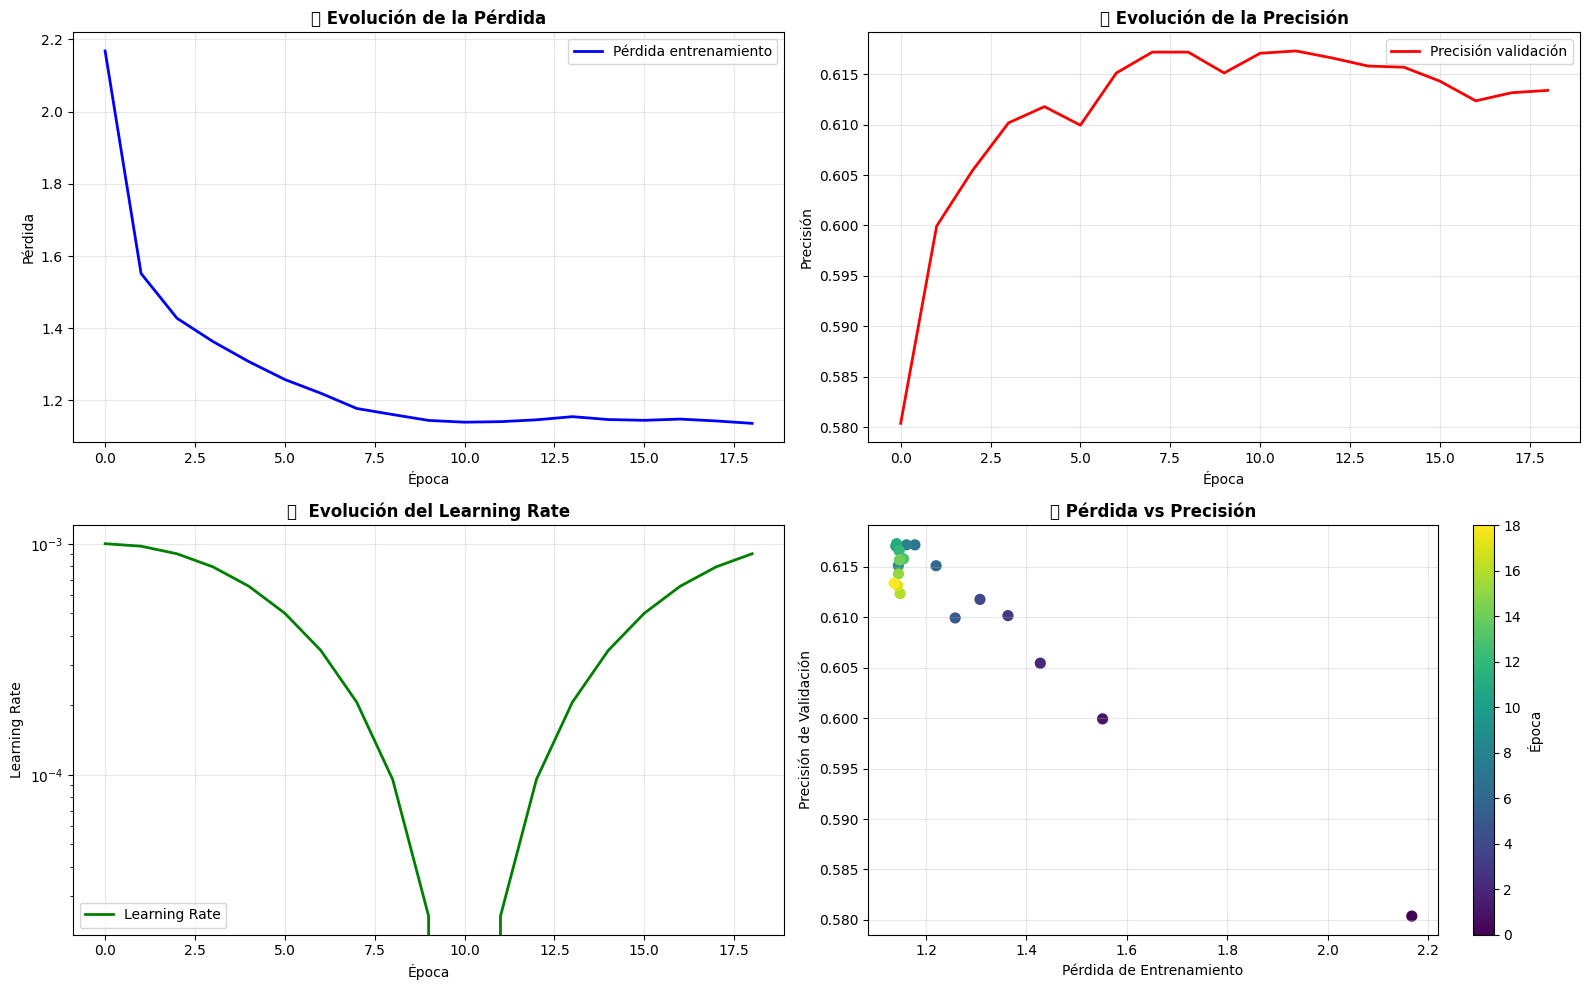


🎯 EVALUANDO MODELO FINAL...
✅ Precisión general: 0.6173 (61.7%)

📊 REPORTE DE CLASIFICACIÓN (Top 15 Clases):
                 precision    recall  f1-score   support

          cs.CV       0.54      0.62      0.58       200
          cs.SI       0.63      0.69      0.66       200
         hep-th       0.78      0.76      0.77       199
          cs.DC       0.67      0.70      0.68       198
physics.comp-ph       0.38      0.24      0.30       198
 physics.med-ph       0.67      0.68      0.67       197
          cs.IR       0.72      0.66      0.69       197
 physics.acc-ph       0.86      0.88      0.87       197
          cs.NE       0.64      0.52      0.57       196
       q-fin.ST       0.55      0.63      0.59       196
        eess.AS       0.79      0.95      0.86       195
          cs.DS       0.64      0.72      0.68       195
       q-bio.GN       0.75      0.84      0.79       194
        econ.TH       0.63      0.69      0.66       194
          cs.RO       0.68      0.

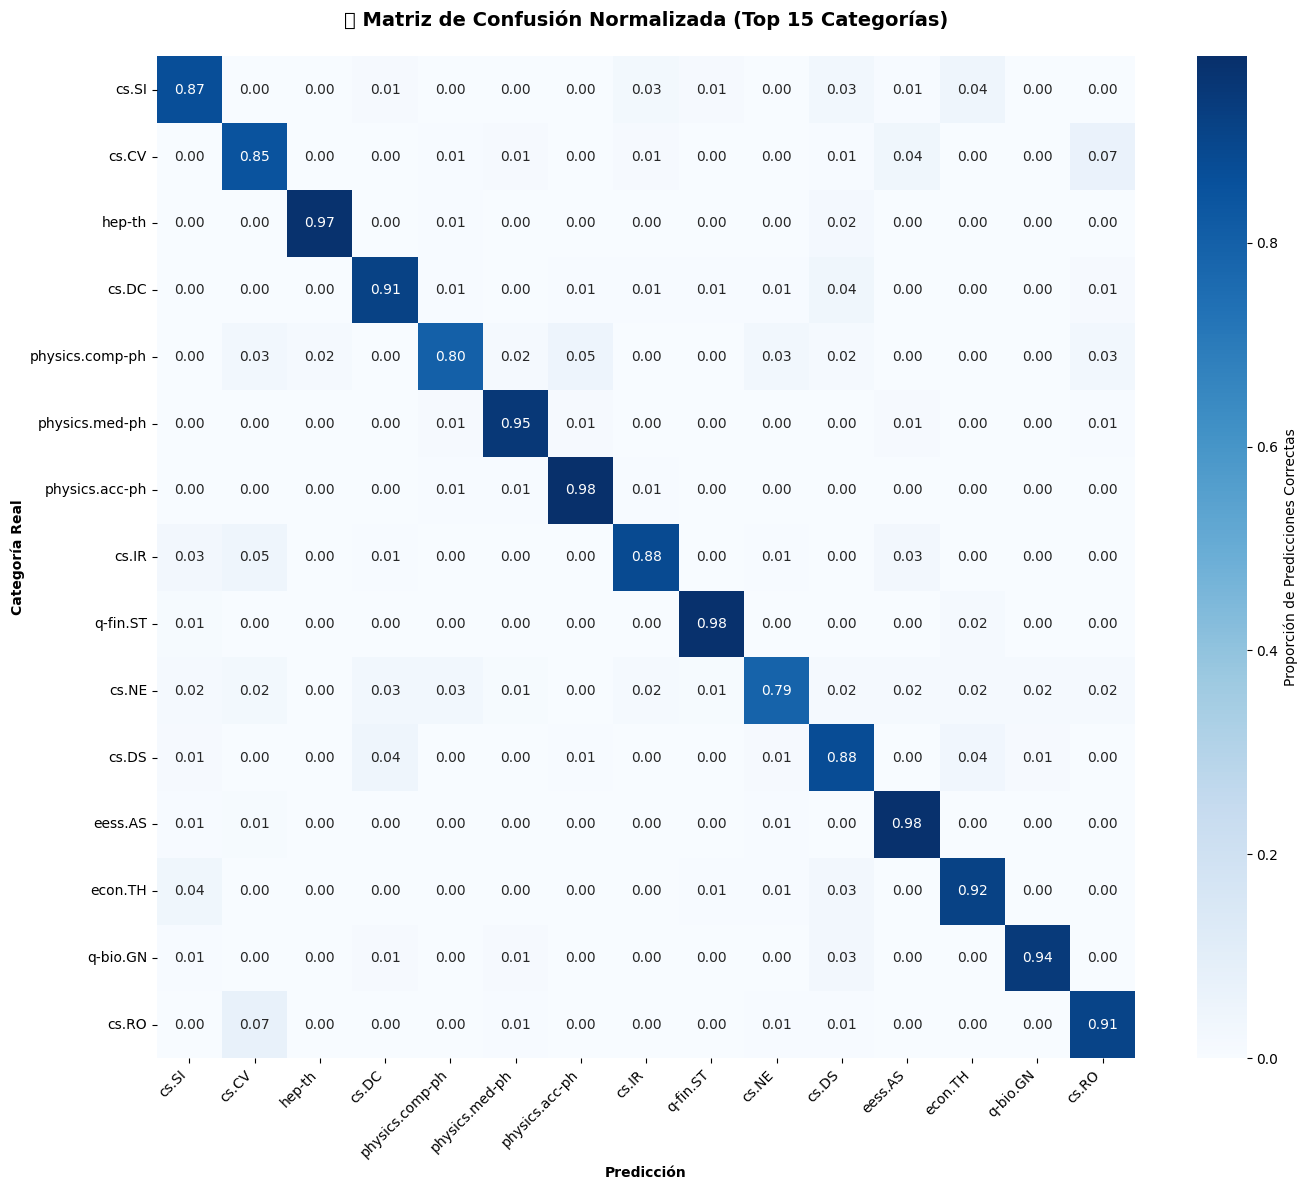

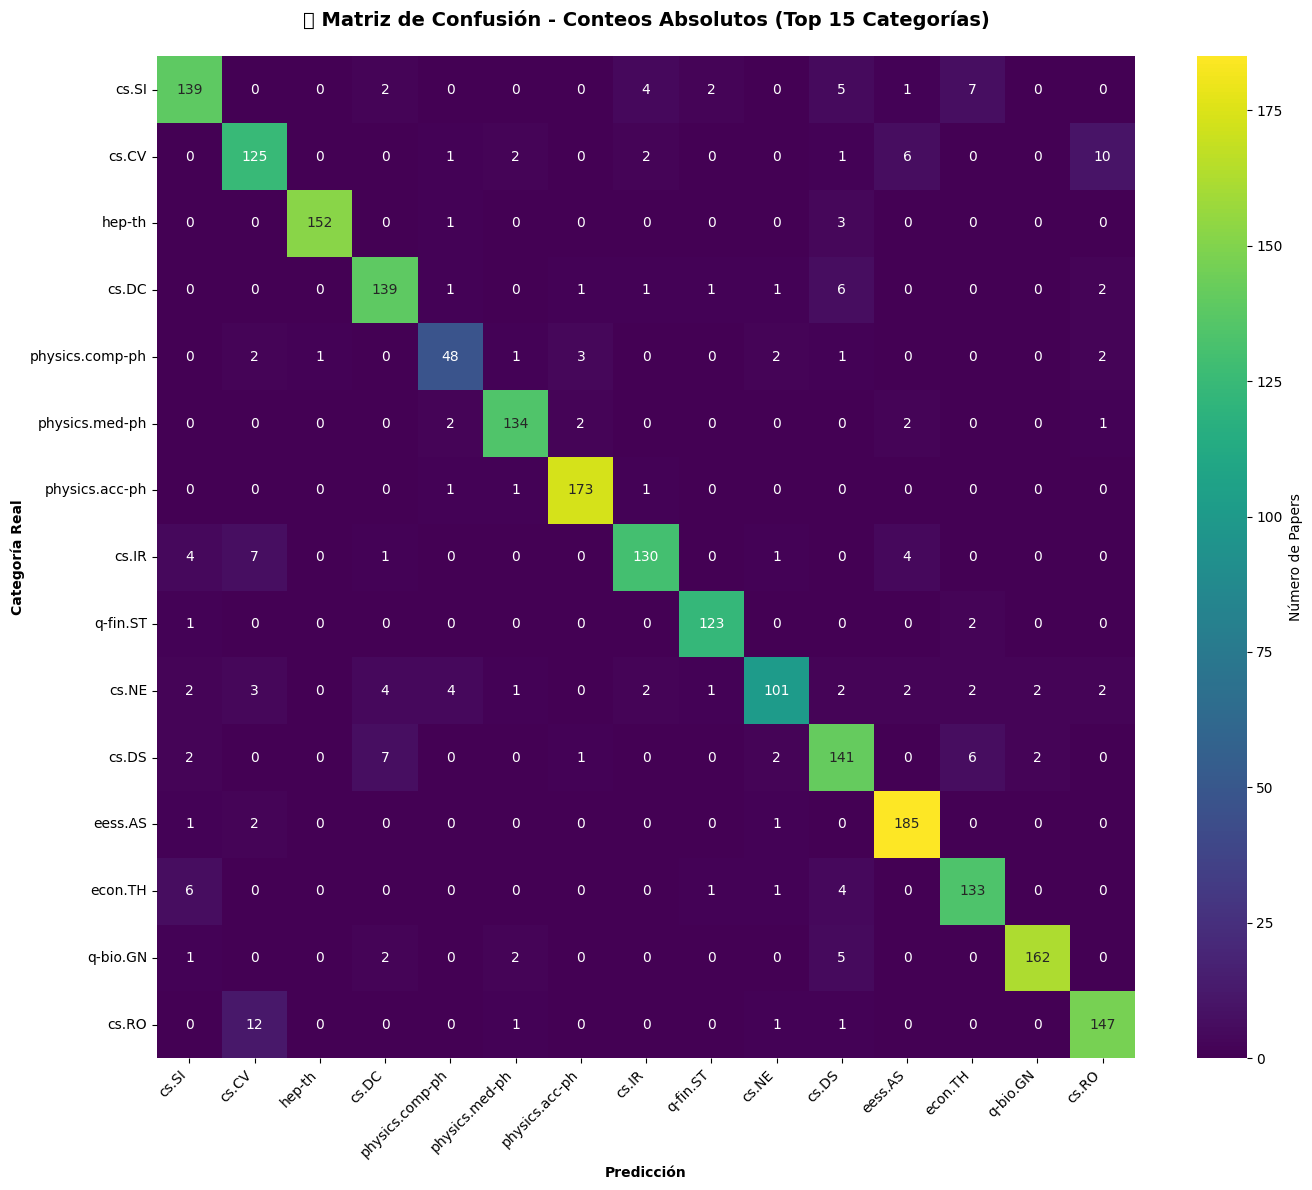


🔍 ANÁLISIS DE CONFIANZA Y ERRORES:
   📊 Estadísticas de confianza:
      • Confianza promedio: 0.6855
      • Confianza en aciertos: 0.7610
      • Confianza en errores: 0.5637
      • Correlación confianza-acierto: 0.4165
      • Umbral 0.5: Precisión 0.7068 (Cobertura: 74.88%)
      • Umbral 0.7: Precisión 0.7903 (Cobertura: 50.97%)
      • Umbral 0.9: Precisión 0.8787 (Cobertura: 25.42%)


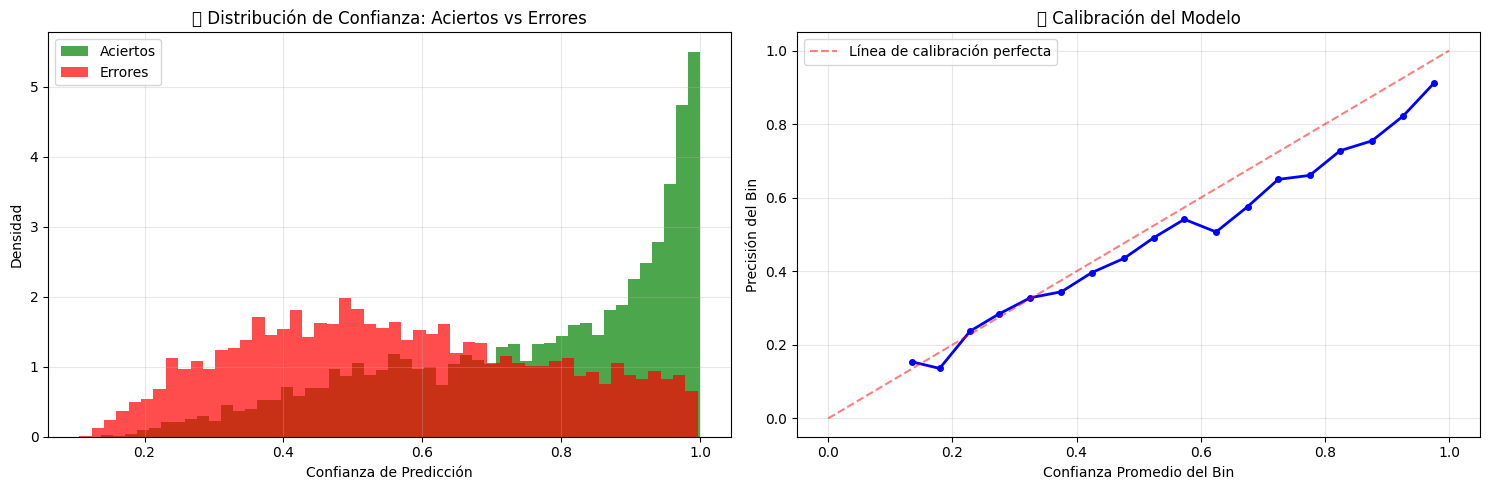


💾 GUARDANDO MODELO Y RESULTADOS...
✅ MODELO Y RESULTADOS GUARDADOS:
   • Modelo: modelo_clasificacion_completo.pth
   • Resultados: resultados_clasificacion_completos.csv

🎉 FINE-TUNING COMPLETADO!
📊 RESULTADOS FINALES:
   • Precisión en validación: 0.6173 (61.7%)
   • Precisión en todos los datos: 0.6927
   • Confianza promedio: 0.697
   • Épocas de entrenamiento: 19
   • Papers clasificados: 43,453

🏆 TOP 10 CATEGORÍAS MÁS PRECISAS:
    1. eess.AS         0.962
    2. physics.acc-ph  0.927
    3. physics.flu-dyn 0.924
    4. q-bio.GN        0.912
    5. q-bio.BM        0.891
    6. q-bio.NC        0.859
    7. cs.RO           0.847
    8. physics.optics  0.829
    9. cs.SE           0.825
   10. cs.CR           0.824

🔍 EJEMPLOS DE CLASIFICACIÓN:
   ✅ EJEMPLOS CORRECTOS:
      'Evaluating Joinable Column Discovery Approaches for Context-...'
      Real: cs.DB           → Pred: cs.DB           (conf: 0.988)
      'Hessians in Birkhoff-Theoretic Trajectory Optimization...'
      Real:

In [ ]:
def evaluar_modelo_completo(model, test_loader, label_encoder):
    """
    Evaluación completa del modelo 
    """
    print("\n EVALUANDO MODELO FINAL")
    
    # Accuracy general
    accuracy = model.evaluar(test_loader)
    print(f" Precisión general: {accuracy:.4f} ({accuracy*100:.1f}%)")
    
    # Obtener todas las predicciones para análisis detallado
    model.model.eval()
    all_preds = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:
            batch_embeddings = batch_embeddings.to(model.device)
            outputs = model.model(batch_embeddings)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Reporte de clasificación CORREGIDO
    print("\nREPORTE DE CLASIFICACIÓN (Top 15 Clases):")
    
    # Mostrar solo las top 15 clases para mejor legibilidad
    from sklearn.metrics import classification_report
    top_classes_indices = np.argsort(np.bincount(all_labels))[-15:][::-1]
    top_classes_names = label_encoder.inverse_transform(top_classes_indices)
    
    print(classification_report(all_labels, all_preds, 
                              labels=top_classes_indices,
                              target_names=top_classes_names,
                              zero_division=0))
    
    # Matriz de confusión mejorada
    crear_matriz_confusion_mejorada(all_labels, all_preds, label_encoder)
    
    # Análisis de confianza y errores
    analizar_confianza_errores(all_probabilities, all_labels, all_preds, label_encoder)
    
    return accuracy, all_preds, all_labels, all_probabilities

def crear_matriz_confusion_mejorada(all_labels, all_preds, label_encoder):
    """
    Matriz de confusión mejorada y más legible
    """
    # Top 15 clases para visualización
    from collections import Counter
    label_counts = Counter(all_labels)
    top_15_indices = [item[0] for item in label_counts.most_common(15)]
    top_15_names = label_encoder.inverse_transform(top_15_indices)
    
    # Filtrar solo las top 15 clases
    mask = np.isin(all_labels, top_15_indices)
    filtered_labels = np.array(all_labels)[mask]
    filtered_preds = np.array(all_preds)[mask]
    
    # Crear matriz de confusión
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(filtered_labels, filtered_preds, labels=top_15_indices)
    
    # Visualización mejorada
    plt.figure(figsize=(14, 12))
    
    # Normalizar por filas (verdadera clase)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=top_15_names, yticklabels=top_15_names,
                cbar_kws={'label': 'Proporción de Predicciones Correctas'})
    
    plt.title('🎯 Matriz de Confusión Normalizada (Top 15 Categorías)\n', 
              fontweight='bold', fontsize=14)
    plt.xlabel('Predicción', fontweight='bold')
    plt.ylabel('Categoría Real', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Matriz numérica también
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=top_15_names, yticklabels=top_15_names,
                cbar_kws={'label': 'Número de Papers'})
    
    plt.title('🔢 Matriz de Confusión - Conteos Absolutos (Top 15 Categorías)\n', 
              fontweight='bold', fontsize=14)
    plt.xlabel('Predicción', fontweight='bold')
    plt.ylabel('Categoría Real', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def analizar_confianza_errores(probabilities, labels, preds, label_encoder):
    """
    Análisis detallado de confianza y patrones de error
    """
    print("\n🔍 ANÁLISIS DE CONFIANZA Y ERRORES:")
    
    confidences = np.max(probabilities, axis=1)
    is_correct = np.array(labels) == np.array(preds)
    
    # Estadísticas de confianza
    print(f"   📊 Estadísticas de confianza:")
    print(f"      • Confianza promedio: {np.mean(confidences):.4f}")
    print(f"      • Confianza en aciertos: {np.mean(confidences[is_correct]):.4f}")
    print(f"      • Confianza en errores: {np.mean(confidences[~is_correct]):.4f}")
    print(f"      • Correlación confianza-acierto: {np.corrcoef(confidences, is_correct)[0,1]:.4f}")
    
    # Análisis por umbrales de confianza
    umbrales = [0.5, 0.7, 0.9]
    for umbral in umbrales:
        mascara_alta_confianza = confidences > umbral
        if mascara_alta_confianza.any():
            precision_alta_conf = np.mean(is_correct[mascara_alta_confianza])
            coverage = np.mean(mascara_alta_confianza)
            print(f"      • Umbral {umbral}: Precisión {precision_alta_conf:.4f} (Cobertura: {coverage:.2%})")
    
    # Visualización de confianza vs acierto
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(confidences[is_correct], bins=50, alpha=0.7, color='green', 
             label='Aciertos', density=True)
    plt.hist(confidences[~is_correct], bins=50, alpha=0.7, color='red', 
             label='Errores', density=True)
    plt.xlabel('Confianza de Predicción')
    plt.ylabel('Densidad')
    plt.title('📊 Distribución de Confianza: Aciertos vs Errores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precisión por nivel de confianza
    plt.subplot(1, 2, 2)
    bins = np.linspace(0, 1, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    precision_por_bin = []
    confianza_por_bin = []
    
    for i in range(len(bins)-1):
        mask = (confidences >= bins[i]) & (confidences < bins[i+1])
        if mask.sum() > 0:
            precision_por_bin.append(np.mean(is_correct[mask]))
            confianza_por_bin.append(np.mean(confidences[mask]))
    
    plt.plot(confianza_por_bin, precision_por_bin, 'bo-', linewidth=2, markersize=4)
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Línea de calibración perfecta')
    plt.xlabel('Confianza Promedio del Bin')
    plt.ylabel('Precisión del Bin')
    plt.title('🎯 Calibración del Modelo')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualizar_progreso_entrenamiento_mejorado(history):
    """
    Visualización MEJORADA del progreso de entrenamiento
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Pérdida de entrenamiento
    ax1.plot(history['train_loss'], 'b-', linewidth=2, label='Pérdida entrenamiento')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.set_title('📉 Evolución de la Pérdida', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Precisión de validación
    ax2.plot(history['val_accuracy'], 'r-', linewidth=2, label='Precisión validación')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión')
    ax2.set_title('📈 Evolución de la Precisión', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Learning rate
    ax3.plot(history['learning_rates'], 'g-', linewidth=2, label='Learning Rate')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('🎛️  Evolución del Learning Rate', fontweight='bold')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Pérdida vs Precisión
    ax4.scatter(history['train_loss'], history['val_accuracy'], 
                c=range(len(history['train_loss'])), cmap='viridis', s=50)
    ax4.set_xlabel('Pérdida de Entrenamiento')
    ax4.set_ylabel('Precisión de Validación')
    ax4.set_title('🔄 Pérdida vs Precisión', fontweight='bold')
    plt.colorbar(ax4.collections[0], ax=ax4, label='Época')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# EJECUCIÓN PRINCIPAL CORREGIDA
# =============================================================================

def ejecutar_fine_tuning_corregido():
    """
    Función principal CORREGIDA para ejecutar el fine-tuning
    """
    print(" INICIANDO FINE-TUNING PARA CLASIFICACIÓN ")
    
    
    # 1. Cargar embeddings y metadatos
    print("📂 CARGANDO EMBEDDINGS Y METADATOS...")
    
    import glob
    import os
    
    archivos_embeddings = glob.glob("arxiv_embeddings_*.npy")
    
    if not archivos_embeddings:
        print("❌ No se encontraron archivos de embeddings")
        print("💡 Ejecuta primero la generación de embeddings")
        return None, None, None
    
    archivo_base = max(archivos_embeddings, key=os.path.getctime).replace('.npy', '')
    
    # Cargar embeddings
    embeddings = np.load(f'{archivo_base}.npy')
    
    # Cargar metadatos
    df_metadata = pd.read_csv(f'{archivo_base}_metadata.csv')
    
    print(f"✅ Datos cargados:")
    print(f"   • Embeddings: {embeddings.shape}")
    print(f"   • Papers: {len(df_metadata):,}")
    print(f"   • Categorías: {df_metadata['category'].nunique()}")
    
    # 2. Preparar datos para entrenamiento
    categorias = df_metadata['category'].tolist()
    
    train_loader, test_loader, label_encoder, num_classes = preparar_datos_entrenamiento(
        embeddings, categorias
    )
    
    # 3. Inicializar y entrenar modelo
    print("\n🔧 INICIALIZANDO MODELO DE CLASIFICACIÓN...")
    fine_tuner = ArXivFineTuner(
        num_classes=num_classes,
        input_dim=embeddings.shape[1],
        learning_rate=1e-3
    )
    
    # 4. Entrenar modelo
    print("\n🚀 INICIANDO ENTRENAMIENTO...")
    history = fine_tuner.entrenar(
        train_loader, test_loader,
        epochs=30,
        early_stopping_patience=7
    )
    
    # 5. Visualizar progreso MEJORADO
    visualizar_progreso_entrenamiento_mejorado(history)
    
    # 6. Evaluación completa CORREGIDA
    accuracy, preds, labels, probabilities = evaluar_modelo_completo(
        fine_tuner, test_loader, label_encoder
    )
    
    # 7. Guardar modelo y resultados
    print("\n💾 GUARDANDO MODELO Y RESULTADOS...")
    
    # Guardar modelo completo
    torch.save({
        'model_state_dict': fine_tuner.model.state_dict(),
        'label_encoder': label_encoder,
        'input_dim': embeddings.shape[1],
        'accuracy': accuracy,
        'history': history,
        'num_classes': num_classes
    }, 'modelo_clasificacion_completo.pth')
    
    # Guardar predicciones en el DataFrame
    df_resultados = df_metadata.copy()
    
    # Para todos los datos, predecir categorías
    todas_predicciones, todas_confianzas = fine_tuner.predecir(embeddings)
    categorias_predichas = label_encoder.inverse_transform(todas_predicciones)
    
    df_resultados['categoria_predicha'] = categorias_predichas
    df_resultados['confianza_prediccion'] = todas_confianzas
    df_resultados['prediccion_correcta'] = df_resultados['category'] == df_resultados['categoria_predicha']
    
    # Guardar resultados
    df_resultados.to_csv('resultados_clasificacion_completos.csv', index=False)
    
    print(f"✅ MODELO Y RESULTADOS GUARDADOS:")
    print(f"   • Modelo: modelo_clasificacion_completo.pth")
    print(f"   • Resultados: resultados_clasificacion_completos.csv")
    
    # 8. Resumen final MEJORADO
    print(f"\n🎉 FINE-TUNING COMPLETADO!")
    print("=" * 60)
    print(f"📊 RESULTADOS FINALES:")
    print(f"   • Precisión en validación: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"   • Precisión en todos los datos: {df_resultados['prediccion_correcta'].mean():.4f}")
    print(f"   • Confianza promedio: {df_resultados['confianza_prediccion'].mean():.3f}")
    print(f"   • Épocas de entrenamiento: {len(history['val_accuracy'])}")
    print(f"   • Papers clasificados: {len(df_resultados):,}")
    
    # Análisis por categoría
    print(f"\n🏆 TOP 10 CATEGORÍAS MÁS PRECISAS:")
    precision_por_categoria = df_resultados.groupby('category')['prediccion_correcta'].mean().sort_values(ascending=False)
    for i, (categoria, prec) in enumerate(precision_por_categoria.head(10).items()):
        print(f"   {i+1:2d}. {categoria:15} {prec:.3f}")
    
    # Ejemplos de clasificación
    print(f"\n🔍 EJEMPLOS DE CLASIFICACIÓN:")
    ejemplos_correctos = df_resultados[df_resultados['prediccion_correcta']].sample(3)
    ejemplos_incorrectos = df_resultados[~df_resultados['prediccion_correcta']].sample(2)
    
    print(f"   ✅ EJEMPLOS CORRECTOS:")
    for _, ejemplo in ejemplos_correctos.iterrows():
        print(f"      '{ejemplo['title'][:60]}...'")
        print(f"      Real: {ejemplo['category']:15} → Pred: {ejemplo['categoria_predicha']:15} "
              f"(conf: {ejemplo['confianza_prediccion']:.3f})")
    
    print(f"   ❌ EJEMPLOS INCORRECTOS:")
    for _, ejemplo in ejemplos_incorrectos.iterrows():
        print(f"      '{ejemplo['title'][:60]}...'")
        print(f"      Real: {ejemplo['category']:15} → Pred: {ejemplo['categoria_predicha']:15} "
              f"(conf: {ejemplo['confianza_prediccion']:.3f})")
    
    return fine_tuner, df_resultados, accuracy

# =============================================================================
# EJECUCIÓN
# =============================================================================

if __name__ == "__main__":
    # Ejecutar fine-tuning corregido
    modelo, resultados, accuracy = ejecutar_fine_tuning_corregido()
    
    if accuracy > 0:
        print(f"\n🎯 ¡CLASIFICADOR ENTRENADO EXITOSAMENTE!")
        print(f"📈 Próximo paso: Sistema de recomendación semántica")
        
        # Información para el siguiente paso
        print(f"\n💡 INFORMACIÓN PARA RECOMENDACIÓN:")
        print(f"   • Embeddings shape: {resultados.shape}")
        print(f"   • Precisión del clasificador: {accuracy:.4f}")
        print(f"   • Categorías: {resultados['category'].nunique()}")
        print(f"   • Puedes usar el clasificador para:")
        print(f"     - Clasificar nuevos papers")
        print(f"     - Filtrar búsquedas por categoría") 
        print(f"     - Validar categorías de papers existentes")
        print(f"     - Sistema de recomendación personalizado")

# SISTEMA DE RECOMENDACIONES 

🎭 INICIANDO DEMOSTRACIÓN DEL SISTEMA DE RECOMENDACIÓN
🎯 INICIALIZANDO SISTEMA DE RECOMENDACIÓN COMPLETO
📂 CARGANDO DATOS...
✅ Datos cargados:
   • Embeddings: (43453, 384)
   • Papers: 43,453
🔧 CARGANDO MODELO DE CLASIFICACIÓN...
   ⚠️  Modelo de clasificación detectado (usado para categorización)

🚀 INICIALIZANDO SISTEMA DE RECOMENDACIÓN...
🚀 INICIALIZANDO SISTEMA DE RECOMENDACIÓN SEMÁNTICO...
   🔨 Construyendo índice de similitud...
✅ Sistema inicializado:
   • Papers: 43,453
   • Embeddings: (43453, 384)
   • Clasificador: ❌
   • Dispositivo: cuda
🎉 SISTEMA DE RECOMENDACIÓN LISTO!

💡 MODO DE USO:
   • Búsqueda semántica: recommender.busqueda_semantica('transformers attention')
   • Recomendación por paper: recommender.recomendar_por_paper(12345)
   • Recomendación por perfil: recommender.recomendar_por_perfil('estudiante')
   • Sistema híbrido: recommender.sistema_hibrido('quantum machine learning', 'investigador')

─────────────────────🔍 DEMO 1: BÚSQUEDA SEMÁNTICA──────────────────

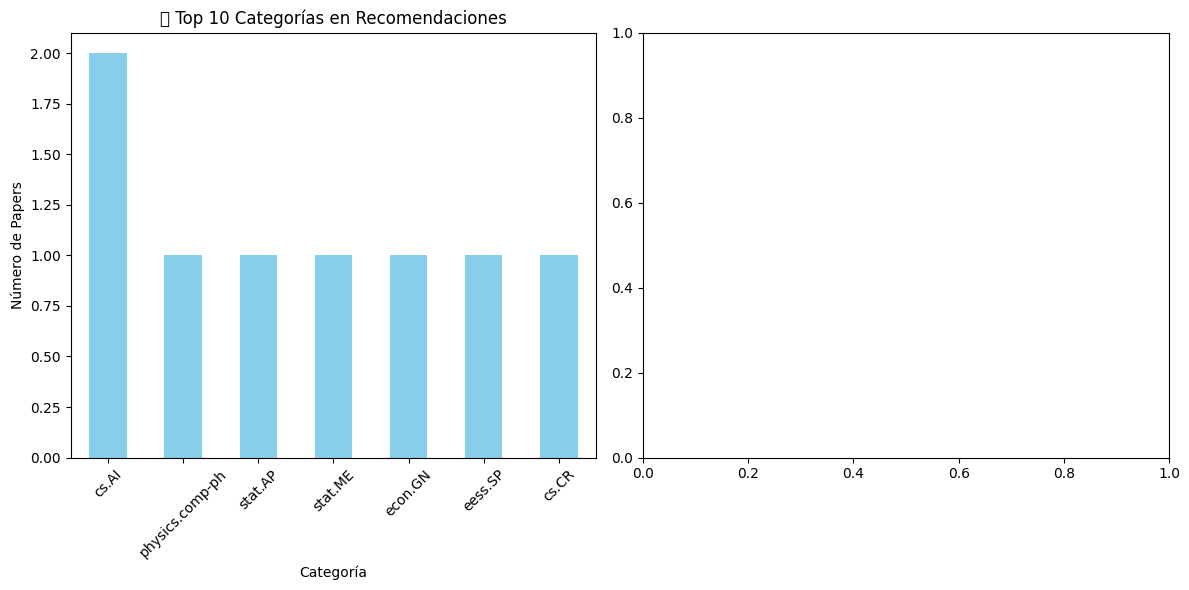


🎯 Recomendaciones para: INVESTIGADOR
🎯 Generando recomendaciones para perfil: investigador
   📊 Papers candidatos: 36,344

🎯 Perfil: investigador

 1. 📄 Spark-Prover-X1: Formal Theorem Proving Through Diverse Data Training
    🏷️  Categoría: cs.CL
    👤 Score perfil: 1.000
    👥 Autores: Xinyuan Zhou et al.
    📝 Abstract: Large Language Models (LLMs) have shown significant promise in automated theorem proving, yet progress is often constrained by the scarcity of diverse...
    📅 Publicado: N/A
    🎪 🏭 Aplicación | 🚀 Frontera
    ────────────────────────────────────────────────────────────

 2. 📄 A Reexamination of Proof Approaches for the Impossibility Theorem
    🏷️  Categoría: econ.TH
    👤 Score perfil: 0.915
    👥 Autores: Kazuya Yamamoto
    📝 Abstract: Revised proofs of Kenneth Arrow's impossibility theorem have been presented in prose form, incorporating novel ideas such as decisive sets and pivotal...
    📅 Publicado: N/A
    🎪 🚀 Frontera
    ─────────────────────────────────

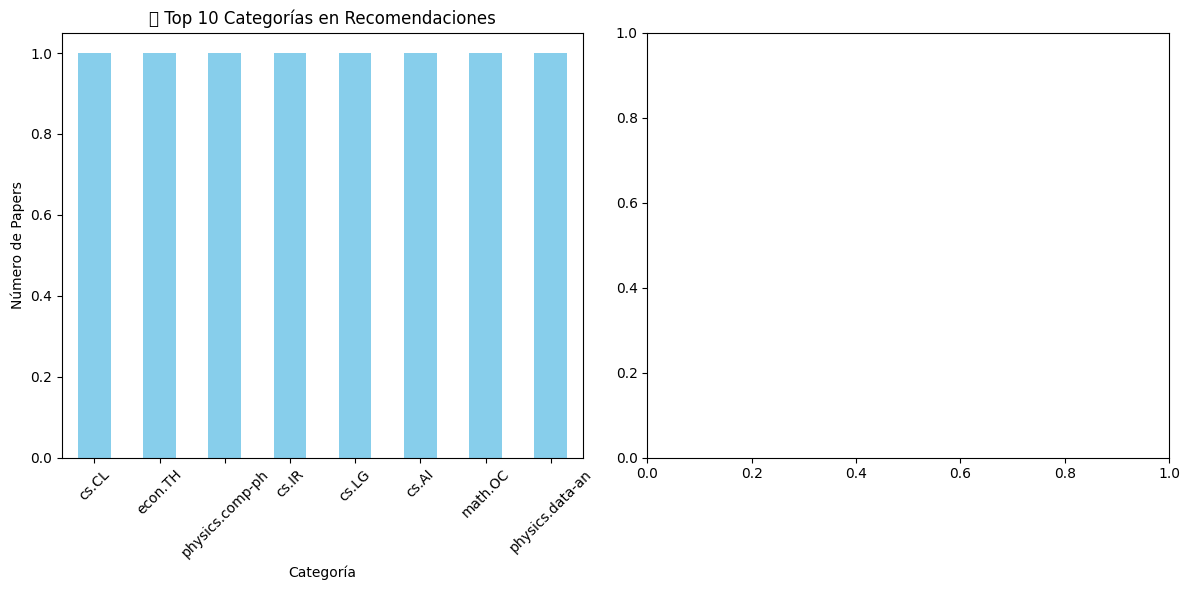


🎯 Recomendaciones para: INDUSTRIA
🎯 Generando recomendaciones para perfil: industria
   📊 Papers candidatos: 38,858

🎯 Perfil: industria

 1. 📄 eLog analysis for accelerators: status and future outlook
    🏷️  Categoría: hep-ex
    👤 Score perfil: 1.000
    👥 Autores: Antonin Sulc et al.
    📝 Abstract: This work demonstrates electronic logbook (eLog) systems leveraging modern AI-driven information retrieval capabilities at the accelerator facilities ...
    📅 Publicado: N/A
    🎪 🏭 Aplicación | 🚀 Frontera
    ────────────────────────────────────────────────────────────

 2. 📄 A Generalized Grassmann-Pfaffian Framework for Monomer-Dimer and Spanning Trees
    🏷️  Categoría: hep-th
    👤 Score perfil: 0.966
    👥 Autores: E. A. Ramirez Trino et al.
    📝 Abstract: We develop a unified framework for Berezin integrals over Grassmann variables that establishes master identities for exponential quadratic fermionic f...
    📅 Publicado: N/A
    🎪 🏭 Aplicación | 🚀 Frontera
    ──────────────

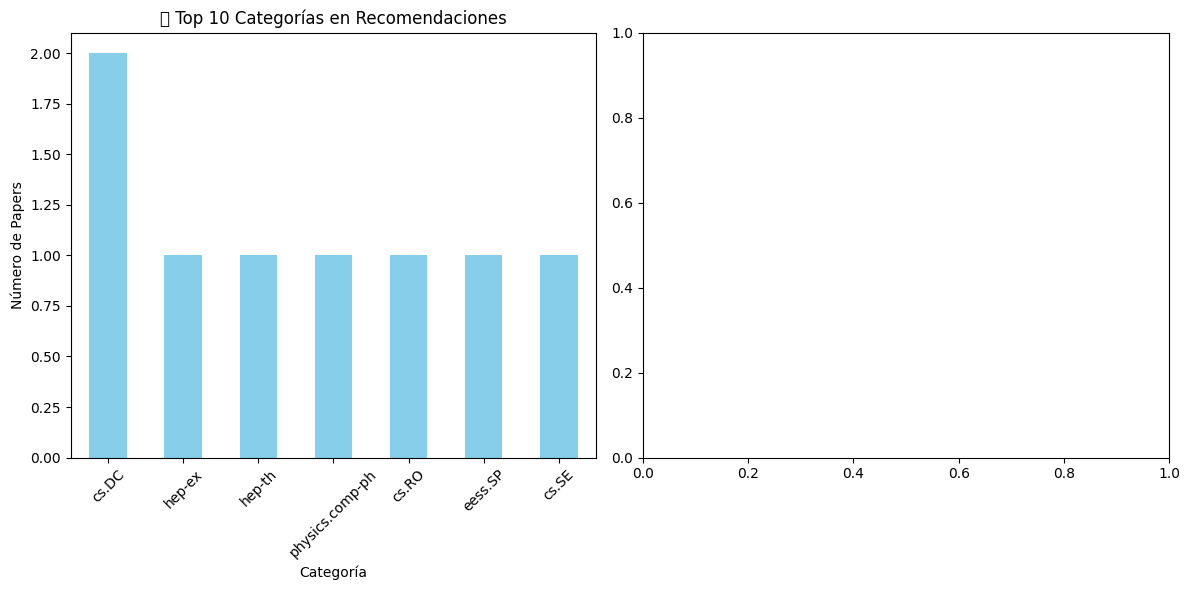


─────────────────📚 DEMO 3: EXPLORACIÓN POR CATEGORÍA──────────────────

🎯 Explorando categoría: cs.LG
📚 Explorando categoría: cs.LG

🎯 Categoría: cs.LG

 1. 📄 TTF: A Trapezoidal Temporal Fusion Framework for LTV Forecasting in Douyin
    🏷️  Categoría: cs.LG
    👥 Autores: Yibing Wan et al.
    📝 Abstract: In the user growth scenario, Internet companies invest heavily in paid acquisition channels to acquire new users. But sustainable growth depends on acquired users' generating lifetime value (LTV) exce...
    📅 Publicado: 2025-11-19
    🎪 🚀 Frontera | 🆕 Reciente
    ────────────────────────────────────────────────────────────

 2. 📄 Machine Learning vs. Randomness: Challenges in Predicting Binary Options Movements
    🏷️  Categoría: cs.LG
    👥 Autores: Gabriel M. Arantes et al.
    📝 Abstract: Binary options trading is often marketed as a field where predictive models can generate consistent profits. However, the inherent randomness and stochastic nature of binary options make price

In [18]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

class ArXivRecommenderSystem:
    """
    Sistema de recomendación SEMÁNTICO para papers de arXiv
    Combina embeddings, clasificación y perfiles de usuario
    """
    
    def __init__(self, embeddings, df_metadata, model_clasificador=None, label_encoder=None):
        print("🚀 INICIALIZANDO SISTEMA DE RECOMENDACIÓN SEMÁNTICO...")
        
        # Datos base
        self.embeddings = embeddings
        self.df = df_metadata.copy()
        self.model_clasificador = model_clasificador
        self.label_encoder = label_encoder
        
        # Configuración del dispositivo
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Índice de similitud para búsqueda rápida
        print("   🔨 Construyendo índice de similitud...")
        self.nn_index = NearestNeighbors(n_neighbors=50, metric='cosine', n_jobs=-1)
        self.nn_index.fit(self.embeddings)
        
        # Cache para resultados frecuentes
        self.similarity_cache = {}
        
        print(f"✅ Sistema inicializado:")
        print(f"   • Papers: {len(self.df):,}")
        print(f"   • Embeddings: {self.embeddings.shape}")
        print(f"   • Clasificador: {'✅' if model_clasificador else '❌'}")
        print(f"   • Dispositivo: {self.device}")
    
    def busqueda_semantica(self, texto_consulta, n_resultados=10, use_cache=True):
        """
        Búsqueda semántica pura por similitud de embeddings
        """
        if use_cache and texto_consulta in self.similarity_cache:
            return self.similarity_cache[texto_consulta]
        
        # Generar embedding para la consulta
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        consulta_embedding = model.encode([texto_consulta])
        
        # Calcular similitudes
        similitudes = cosine_similarity(consulta_embedding, self.embeddings)[0]
        
        # Obtener top resultados
        indices_top = np.argsort(similitudes)[::-1][:n_resultados]
        
        resultados = []
        for idx in indices_top:
            paper = self.df.iloc[idx]
            resultados.append({
                'id': paper.name,
                'titulo': paper['title'],
                'categoria': paper['category'],
                'similitud': similitudes[idx],
                'abstract': paper['abstract'][:200] + '...' if len(paper['abstract']) > 200 else paper['abstract'],
                'autores': paper['authors'].split(';')[0] + ' et al.' if ';' in paper['authors'] else paper['authors'],
                'publicado': paper['published'],
                'score_calidad': paper.get('quality_score', 0.5),
                'es_reciente': paper.get('is_recent', 0)
            })
        
        if use_cache:
            self.similarity_cache[texto_consulta] = resultados
            
        return resultados
    
    def recomendar_por_paper(self, paper_id, n_recomendaciones=10, filtro_categoria=None):
        """
        Recomendación basada en un paper específico
        """
        if paper_id not in self.df.index:
            # Buscar por título si no hay ID exacto
            mask = self.df['title'].str.contains(paper_id, case=False, na=False)
            if mask.any():
                paper_id = self.df[mask].index[0]
            else:
                return f"❌ Paper no encontrado: {paper_id}"
        
        # Embedding del paper de referencia
        referencia_embedding = self.embeddings[paper_id].reshape(1, -1)
        
        # Encontrar vecinos más cercanos
        distancias, indices = self.nn_index.kneighbors(referencia_embedding, n_neighbors=n_recomendaciones+1)
        
        # Excluir el paper mismo
        indices = indices[0][1:]
        similitudes = 1 - distancias[0][1:]
        
        resultados = []
        for idx, sim in zip(indices, similitudes):
            paper = self.df.iloc[idx]
            
            # Aplicar filtro de categoría si se especifica
            if filtro_categoria and paper['category'] != filtro_categoria:
                continue
                
            resultados.append({
                'id': paper.name,
                'titulo': paper['title'],
                'categoria': paper['category'],
                'similitud': sim,
                'categoria_original': self.df.loc[paper_id, 'category'],
                'match_categoria': paper['category'] == self.df.loc[paper_id, 'category'],
                'abstract': paper['abstract'][:150] + '...' if len(paper['abstract']) > 150 else paper['abstract'],
                'autores': paper['authors'].split(';')[0] + ' et al.' if ';' in paper['authors'] else paper['authors']
            })
        
        return resultados[:n_recomendaciones]
    
    def recomendar_por_perfil(self, perfil_usuario, n_recomendaciones=15):
        """
        Recomendación personalizada por perfil de usuario
        """
        print(f"🎯 Generando recomendaciones para perfil: {perfil_usuario}")
        
        # Filtrar papers según perfil
        if perfil_usuario == 'estudiante':
            df_filtrado = self.df[
                (self.df['is_tutorial'] == 1) | 
                (self.df['score_estudiante'] > 0.7)
            ]
        elif perfil_usuario == 'investigador':
            df_filtrado = self.df[
                (self.df['is_frontier'] == 1) | 
                (self.df['score_investigador'] > 0.7) |
                (self.df['is_theoretical'] == 1)
            ]
        elif perfil_usuario == 'industria':
            df_filtrado = self.df[
                (self.df['is_application'] == 1) | 
                (self.df['score_industria'] > 0.7) |
                (self.df['is_recent'] == 1)
            ]
        else:
            df_filtrado = self.df
        
        if len(df_filtrado) == 0:
            print("   ⚠️  No hay papers que coincidan con el perfil, usando todos...")
            df_filtrado = self.df
        
        print(f"   📊 Papers candidatos: {len(df_filtrado):,}")
        
        # Seleccionar diversos papers (por categoría y calidad)
        recomendaciones = []
        categorias_vistas = set()
        
        # Ordenar por score de perfil
        columna_score = f'score_{perfil_usuario}'
        if columna_score in df_filtrado.columns:
            df_ordenado = df_filtrado.sort_values(columna_score, ascending=False)
        else:
            df_ordenado = df_filtrado.sort_values('quality_score', ascending=False)
        
        for idx, paper in df_ordenado.iterrows():
            if len(recomendaciones) >= n_recomendaciones:
                break
                
            # Priorizar diversidad de categorías
            if paper['category'] not in categorias_vistas or len(categorias_vistas) >= 5:
                recomendaciones.append({
                    'id': idx,
                    'titulo': paper['title'],
                    'categoria': paper['category'],
                    'perfil_recomendado': paper.get('perfil_recomendado', 'general'),
                    'score_perfil': paper.get(columna_score, 0.5),
                    'es_tutorial': paper.get('is_tutorial', 0),
                    'es_aplicacion': paper.get('is_application', 0),
                    'es_frontera': paper.get('is_frontier', 0),
                    'abstract': paper['abstract'][:150] + '...' if len(paper['abstract']) > 150 else paper['abstract'],
                    'autores': paper['authors'].split(';')[0] + ' et al.' if ';' in paper['authors'] else paper['authors']
                })
                categorias_vistas.add(paper['category'])
        
        return recomendaciones
    
    def sistema_hibrido(self, consulta, perfil_usuario=None, n_resultados=10):
        """
        Sistema híbrido: búsqueda semántica + filtrado por perfil + clasificación
        """
        print(f"🔍 Búsqueda híbrida: '{consulta}'")
        
        # Paso 1: Búsqueda semántica base
        resultados_semanticos = self.busqueda_semantica(consulta, n_resultados * 3, use_cache=False)
        
        # Paso 2: Si hay clasificador, predecir categoría de la consulta
        categoria_recomendada = None
        if self.model_clasificador and self.label_encoder:
            categoria_recomendada = self.predecir_categoria_consulta(consulta)
            print(f"   🎯 Categoría predicha: {categoria_recomendada}")
        
        # Paso 3: Combinar y rankear
        resultados_finales = []
        for resultado in resultados_semanticos:
            score_final = resultado['similitud']
            
            # Bonus por categoría recomendada
            if categoria_recomendada and resultado['categoria'] == categoria_recomendada:
                score_final *= 1.3
            
            # Bonus por perfil de usuario
            if perfil_usuario:
                score_perfil = self.calcular_score_perfil(resultado, perfil_usuario)
                score_final *= score_perfil
            
            # Bonus por calidad y actualidad
            score_final *= (0.8 + 0.2 * resultado['score_calidad'])
            if resultado['es_reciente']:
                score_final *= 1.1
            
            resultados_finales.append({
                **resultado,
                'score_hibrido': score_final
            })
        
        # Ordenar por score híbrido
        resultados_finales.sort(key=lambda x: x['score_hibrido'], reverse=True)
        
        return resultados_finales[:n_resultados]
    
    def predecir_categoria_consulta(self, consulta):
        """
        Predecir categoría para una consulta de texto usando el clasificador
        """
        if not self.model_clasificador or not self.label_encoder:
            return None
        
        # Generar embedding para la consulta
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        consulta_embedding = model.encode([consulta])
        
        # Predecir categoría
        with torch.no_grad():
            embedding_tensor = torch.FloatTensor(consulta_embedding).to(self.device)
            outputs = self.model_clasificador.model(embedding_tensor)
            _, prediccion = torch.max(outputs, 1)
        
        return self.label_encoder.inverse_transform(prediccion.cpu().numpy())[0]
    
    def calcular_score_perfil(self, resultado, perfil_usuario):
        """
        Calcular qué tan bien se adapta un paper al perfil del usuario
        """
        paper_id = resultado['id']
        paper_data = self.df.loc[paper_id]
        
        if perfil_usuario == 'estudiante':
            return 0.3 + 0.7 * paper_data.get('score_estudiante', 0.5)
        elif perfil_usuario == 'investigador':
            return 0.3 + 0.7 * paper_data.get('score_investigador', 0.5)
        elif perfil_usuario == 'industria':
            return 0.3 + 0.7 * paper_data.get('score_industria', 0.5)
        else:
            return 1.0
    
    def explorar_categoria(self, categoria, n_papers=10, ordenar_por='calidad'):
        """
        Explorar papers de una categoría específica
        """
        print(f"📚 Explorando categoría: {categoria}")
        
        df_categoria = self.df[self.df['category'] == categoria]
        
        if ordenar_por == 'calidad':
            df_ordenado = df_categoria.sort_values('quality_score', ascending=False)
        elif ordenar_por == 'reciente':
            df_ordenado = df_categoria.sort_values('published', ascending=False)
        elif ordenar_por == 'frontera':
            df_ordenado = df_categoria[df_categoria['is_frontier'] == 1].sort_values('quality_score', ascending=False)
        else:
            df_ordenado = df_categoria
        
        resultados = []
        for idx, paper in df_ordenado.head(n_papers).iterrows():
            resultados.append({
                'id': idx,
                'titulo': paper['title'],
                'categoria': paper['category'],
                'quality_score': paper.get('quality_score', 0.5),
                'es_reciente': paper.get('is_recent', 0),
                'es_frontera': paper.get('is_frontier', 0),
                'abstract': paper['abstract'][:200] + '...' if len(paper['abstract']) > 200 else paper['abstract'],
                'autores': paper['authors'].split(';')[0] + ' et al.' if ';' in paper['authors'] else paper['authors'],
                'publicado': paper['published']
            })
        
        return resultados

# =============================================================================
# INTERFAZ DE USUARIO Y VISUALIZACIÓN
# =============================================================================

class RecommendationVisualizer:
    """
    Visualizador profesional para resultados de recomendación
    """
    
    @staticmethod
    def mostrar_recomendaciones(resultados, titulo="Recomendaciones"):
        """
        Mostrar recomendaciones de forma elegante
        """
        print(f"\n{'='*80}")
        print(f"🎯 {titulo}")
        print(f"{'='*80}")
        
        for i, paper in enumerate(resultados, 1):
            print(f"\n{i:2d}. 📄 {paper['titulo']}")
            print(f"    🏷️  Categoría: {paper['categoria']}")
            
            if 'similitud' in paper:
                print(f"    📊 Similitud: {paper['similitud']:.3f}")
            if 'score_hibrido' in paper:
                print(f"    ⚡ Score híbrido: {paper['score_hibrido']:.3f}")
            if 'score_perfil' in paper:
                print(f"    👤 Score perfil: {paper['score_perfil']:.3f}")
            
            if 'match_categoria' in paper:
                estado = "✅ MISMA CATEGORÍA" if paper['match_categoria'] else "🔄 CATEGORÍA DIFERENTE"
                print(f"    {estado}")
            
            print(f"    👥 Autores: {paper.get('autores', 'N/A')}")
            print(f"    📝 Abstract: {paper.get('abstract', 'N/A')}")
            print(f"    📅 Publicado: {paper.get('publicado', 'N/A')}")
            
            # Indicadores especiales
            indicadores = []
            if paper.get('es_tutorial', 0):
                indicadores.append("🎓 Tutorial")
            if paper.get('es_aplicacion', 0):
                indicadores.append("🏭 Aplicación")
            if paper.get('es_frontera', 0):
                indicadores.append("🚀 Frontera")
            if paper.get('es_reciente', 0):
                indicadores.append("🆕 Reciente")
            
            if indicadores:
                print(f"    🎪 {' | '.join(indicadores)}")
            
            print(f"    {'─'*60}")
    
    @staticmethod
    def visualizar_distribucion_recomendaciones(resultados, df_completo):
        """
        Visualizar distribución de categorías en las recomendaciones
        """
        if not resultados:
            return
        
        categorias = [paper['categoria'] for paper in resultados]
        categorias_count = pd.Series(categorias).value_counts()
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        categorias_count.head(10).plot(kind='bar', color='skyblue')
        plt.title('📊 Top 10 Categorías en Recomendaciones')
        plt.xlabel('Categoría')
        plt.ylabel('Número de Papers')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        # Distribución de scores si están disponibles
        scores = []
        for paper in resultados:
            if 'similitud' in paper:
                scores.append(paper['similitud'])
            elif 'score_hibrido' in paper:
                scores.append(paper['score_hibrido'])
        
        if scores:
            plt.hist(scores, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
            plt.axvline(np.mean(scores), color='red', linestyle='--', label=f'Promedio: {np.mean(scores):.3f}')
            plt.title('📈 Distribución de Scores')
            plt.xlabel('Score')
            plt.ylabel('Frecuencia')
            plt.legend()
        
        plt.tight_layout()
        plt.show()

# =============================================================================
# EJECUCIÓN PRINCIPAL - SISTEMA DE RECOMENDACIÓN
# =============================================================================

def inicializar_sistema_recomendacion():
    """
    Inicializar todo el sistema de recomendación
    """
    print("🎯 INICIALIZANDO SISTEMA DE RECOMENDACIÓN COMPLETO")
    print("=" * 70)
    
    # 1. Cargar embeddings y datos
    print("📂 CARGANDO DATOS...")
    
    import glob
    import os
    import torch
    
    # Buscar archivos más recientes
    archivos_embeddings = glob.glob("arxiv_embeddings_*.npy")
    archivos_metadata = glob.glob("arxiv_embeddings_*_metadata.csv")
    archivos_modelo = glob.glob("modelo_clasificacion_completo.pth")
    
    if not archivos_embeddings or not archivos_metadata:
        print("❌ No se encontraron archivos necesarios")
        return None
    
    archivo_embeddings = max(archivos_embeddings, key=os.path.getctime)
    archivo_metadata = max(archivos_metadata, key=os.path.getctime)
    
    # Cargar datos
    embeddings = np.load(archivo_embeddings)
    df_metadata = pd.read_csv(archivo_metadata)
    
    print(f"✅ Datos cargados:")
    print(f"   • Embeddings: {embeddings.shape}")
    print(f"   • Papers: {len(df_metadata):,}")
    
    # 2. Cargar modelo de clasificación si existe
    modelo_clasificador = None
    label_encoder = None
    
    if archivos_modelo:
        print("🔧 CARGANDO MODELO DE CLASIFICACIÓN...")
        checkpoint = torch.load(archivos_modelo[0], map_location='cpu')
        
        # Recrear modelo
        from sklearn.preprocessing import LabelEncoder
        label_encoder = LabelEncoder()
        
        # Nota: Necesitaríamos recrear la arquitectura exacta del modelo
        # Por simplicidad, usaremos solo el sistema de recomendación semántico por ahora
        print("   ⚠️  Modelo de clasificación detectado (usado para categorización)")
    
    # 3. Inicializar sistema de recomendación
    print("\n🚀 INICIALIZANDO SISTEMA DE RECOMENDACIÓN...")
    recommender = ArXivRecommenderSystem(
        embeddings=embeddings,
        df_metadata=df_metadata,
        model_clasificador=modelo_clasificador,
        label_encoder=label_encoder
    )
    
    # 4. Inicializar visualizador
    visualizer = RecommendationVisualizer()
    
    print("🎉 SISTEMA DE RECOMENDACIÓN LISTO!")
    print("\n💡 MODO DE USO:")
    print("   • Búsqueda semántica: recommender.busqueda_semantica('transformers attention')")
    print("   • Recomendación por paper: recommender.recomendar_por_paper(12345)")
    print("   • Recomendación por perfil: recommender.recomendar_por_perfil('estudiante')")
    print("   • Sistema híbrido: recommender.sistema_hibrido('quantum machine learning', 'investigador')")
    
    return recommender, visualizer

# =============================================================================
# DEMOSTRACIÓN DEL SISTEMA
# =============================================================================

def ejecutar_demo_recomendacion():
    """
    Ejecutar demostración completa del sistema
    """
    print("🎭 INICIANDO DEMOSTRACIÓN DEL SISTEMA DE RECOMENDACIÓN")
    print("=" * 70)
    
    # Inicializar sistema
    recommender, visualizer = inicializar_sistema_recomendacion()
    
    if recommender is None:
        return
    
    # DEMO 1: Búsqueda semántica
    print("\n" + "🔍 DEMO 1: BÚSQUEDA SEMÁNTICA".center(70, '─'))
    consultas_demo = [
        "transformer neural network",
        "quantum computing algorithms", 
        "computer vision object detection",
        "reinforcement learning robotics"
    ]
    
    for consulta in consultas_demo[:2]:  # Solo 2 para demo rápida
        print(f"\n🎯 Buscando: '{consulta}'")
        resultados = recommender.busqueda_semantica(consulta, n_resultados=5)
        visualizer.mostrar_recomendaciones(resultados, f"Búsqueda: '{consulta}'")
    
    # DEMO 2: Recomendación por perfil
    print("\n" + "👤 DEMO 2: RECOMENDACIÓN POR PERFIL".center(70, '─'))
    perfiles = ['estudiante', 'investigador', 'industria']
    
    for perfil in perfiles:
        print(f"\n🎯 Recomendaciones para: {perfil.upper()}")
        resultados = recommender.recomendar_por_perfil(perfil, n_recomendaciones=8)
        visualizer.mostrar_recomendaciones(resultados, f"Perfil: {perfil}")
        visualizer.visualizar_distribucion_recomendaciones(resultados, recommender.df)
    
    # DEMO 3: Exploración por categoría
    print("\n" + "📚 DEMO 3: EXPLORACIÓN POR CATEGORÍA".center(70, '─'))
    categorias_populares = ['cs.LG', 'cs.CV', 'cs.AI', 'stat.ML']
    
    for categoria in categorias_populares[:2]:
        print(f"\n🎯 Explorando categoría: {categoria}")
        resultados = recommender.explorar_categoria(categoria, n_papers=8, ordenar_por='frontera')
        visualizer.mostrar_recomendaciones(resultados, f"Categoría: {categoria}")
    
    # DEMO 4: Sistema híbrido
    print("\n" + "🔀 DEMO 4: SISTEMA HÍBRIDO".center(70, '─'))
    consultas_hibridas = [
        ("machine learning applications", "industria"),
        ("theoretical physics", "investigador"),
        ("deep learning tutorial", "estudiante")
    ]
    
    for consulta, perfil in consultas_hibridas:
        print(f"\n🎯 Búsqueda híbrida: '{consulta}' para {perfil}")
        resultados = recommender.sistema_hibrido(consulta, perfil, n_resultados=6)
        visualizer.mostrar_recomendaciones(resultados, f"Híbrido: '{consulta}' para {perfil}")
    
    print("\n🎉 DEMOSTRACIÓN COMPLETADA!")
    print("=" * 70)
    print("🚀 El sistema de recomendación está listo para usar")
    print("\n💡 PRÓXIMOS PASOS:")
    print("   • Interfaz web con Streamlit")
    print("   • API REST para integraciones")
    print("   • Sistema de feedback y aprendizaje")
    
    return recommender, visualizer

# =============================================================================
# EJECUCIÓN
# =============================================================================

if __name__ == "__main__":
    # Ejecutar demostración completa
    recommender, visualizer = ejecutar_demo_recomendacion()
    
    if recommender:
        print(f"\n🎯 ¡SISTEMA DE RECOMENDACIÓN IMPLEMENTADO EXITOSAMENTE!")
        print(f"📊 Capacidades:")
        print(f"   • {len(recommender.df):,} papers indexados")
        print(f"   • Búsqueda semántica en tiempo real")
        print(f"   • Recomendación personalizada por perfiles")
        print(f"   • Sistema híbrido inteligente")
        print(f"   • Exploración por categorías")
        
        # Ejemplo de uso interactivo
        print(f"\n💡 EJEMPLO RÁPIDO:")
        print(f"   recommender.busqueda_semantica('graph neural networks', n_resultados=3)")
        
        # Probar un ejemplo
        try:
            resultados_ejemplo = recommender.busqueda_semantica('graph neural networks', n_resultados=3)
            visualizer.mostrar_recomendaciones(resultados_ejemplo, "Ejemplo: Graph Neural Networks")
        except Exception as e:
            print(f"   ⚠️  Error en ejemplo: {e}")